###GOAL: Create a method to iteratively identify all the KOs/COs assocaited with a CO for compounds identified as interesting by Krista in the NB study
Here I am going to employ *beautiful soup* to parse the html websites of the different COs within KEGG to identify the KOs that are associated with a given CO. I have a list of ~100 Compounds identified by Krista.  Here I am going to pull all the data assocaited with each of those compounds with the hopes of linking the changes in concentrations with changes in relative gene transcript abundance. 

In [335]:
import pandas as pd
import urllib2
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import palettable as pal

%matplotlib inline

In [319]:
CO_RawData=pd.read_csv('RImetabolites.2015.06.02.csv', index_col='cNumber')
KO_RawData=pd.read_csv('AllPhytoKegg_KO_counts.tab', index_col='gID', delimiter='\t')
KO_RawData=KO_RawData[KO_RawData.sum(axis=1)!=0]
CO_RawData=CO_RawData[CO_RawData.sum(axis=1)!=0]

First-- taking a look at how the raw data is distributed.  I need to run a goodness of fit test-- but it appears that both datasets are similarly distributed (poisson perhaps?)

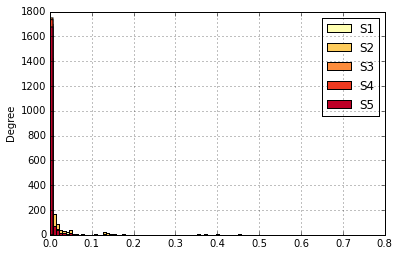

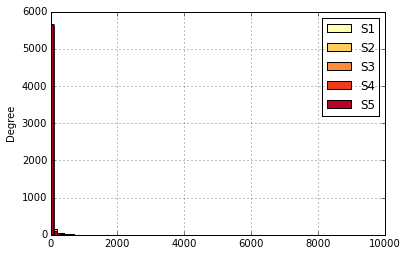

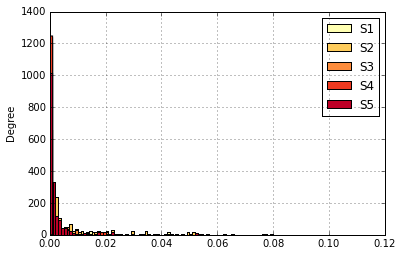

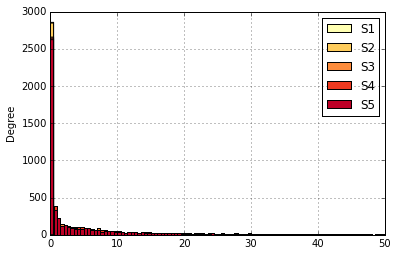

In [333]:

cmap=pal.colorbrewer.sequential.YlOrRd_5.get_mpl_colormap()
CO_RawData.plot(kind='hist', bins=100,colormap=cmap)
KO_RawData.plot(kind='hist', bins=100,colormap=cmap)
CO_RawData.plot(kind='hist',  bins=100,colormap=cmap, range = [0,0.1])
KO_RawData.plot(kind='hist',  bins=100,colormap=cmap, range = [0,50])

It is quite evident that the dataset have very different ranges.  0.000-0.8 and 0-10,000. So, I need to figure out a good way to normalize the data.  I am not totally sure what the best way to do it is, but let's give dividing by the mean a try.  That will wash outthe differences in magnitude. These distributions look similar-- but also suggest that the coverage of the CO data is less (not surprising-- fewer genes etc.)

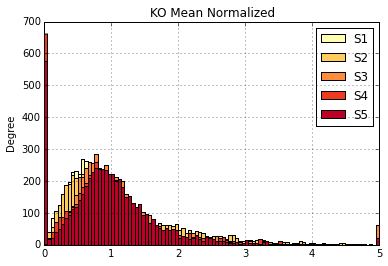

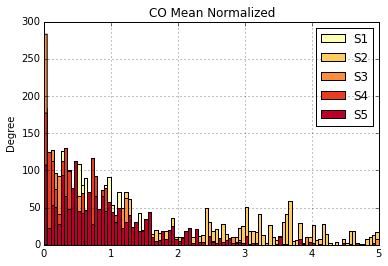

In [334]:
def NormalizeToMean(DF):
    DF['mean']=DF.mean(axis=1)
    DF_meanNorm=DF.copy()
    for i in DF.columns:
        DF_meanNorm[i]=DF[i]/DF['mean']
    DF_meanNorm=DF_meanNorm.T.drop('mean').T
    return DF_meanNorm




CO_Norm2Mean=NormalizeToMean(CO_RawData)
KO_Norm2Mean=NormalizeToMean(KO_RawData)
cmap=pal.colorbrewer.sequential.YlOrRd_5.get_mpl_colormap()
kplt=KO_Norm2Mean.plot(kind='hist', bins=100, title='KO Mean Normalized', colormap=cmap)
plt.savefig('KOMeanNormalized_Histogram.png')
cplt=CO_Norm2Mean.plot(kind='hist', bins=100, title='CO Mean Normalized', colormap=cmap)
plt.savefig('COMeanNormalized_Histogram.png')



Why not compare the two coefficients of variation. Why does it cap off at 2? That is weird. 

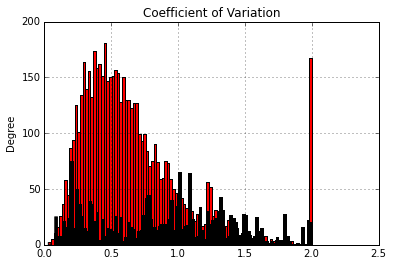

In [347]:
def NormalizeToMean_CV(DF):
    out=DF.copy()
    out['mean']=DF.mean(axis=1)
    out['SD']=DF.std(axis=1)
    
    out['CV']=out['SD']/out['mean']
    return out
cmap=pal.colorbrewer.diverging.PRGn_5.get_mpl_colormap()
fig,ax=plt.subplots(1)
CO_CV=NormalizeToMean_CV(CO_RawData)
KO_CV=NormalizeToMean_CV(KO_RawData)
# KO_CV.CV.plot(kind='hist', ax=ax, bins=100, title='CO Mean Normalized', colormap=cmap)
KO_CV.CV.plot(kind='hist', ax=ax, bins=100, color='r')
CO_CV.CV.plot(kind='hist', ax=ax, bins=100, title='Coefficient of Variation', color='k')
fig.savefig('Coefficent of Variation')

####Check the CO data out and see if anything in particular looks interesting. 
The below script is pitifully slow-- so I think it would take a very long time to process ~1000 tags. etc. 

In [ ]:
#Here I was working on getting these data integrated into aprogram; That program was 
#written and saved as CreateHash_COtoKO.py. So, these are obsolete as of 2 June 2015. 


def getROData(RO):
    #get the KO/CO data associated with a reaction
    RO_httpstr='http://www.genome.jp/dbget-bin/www_bget?rn:'
    ROsite=urllib2.urlopen(RO_httpstr+RO)
    Rsoup=BeautifulSoup(ROsite)
    Rtable=Rsoup.table
    KOlist=Rtable.findAll(text=re.compile('K[0-9]{,5}$'))
    KOlist=[str(item) for item in KOlist]
    COlist=Rtable.findAll(text=re.compile('^C[0-9]{,5}$'))
    COlist=[str(item) for item in COlist]

    return KOlist, COlist
    
def getKOfromCO(COid):
    #Function to find and locate pertenant information about the CO (compound) ids
    #Get the website that we want by adding this string to the input
    CO_httpstr='http://www.genome.jp/dbget-bin/www_bget?cpd:'
    CO_httpfull=CO_httpstr+COid
    COsite=urllib2.urlopen(CO_httpfull)
#     Use beautiful soup to parse the website
    Csoup = BeautifulSoup(COsite)
    #Identify the table on the website
    COtable=Csoup.table
    #Find all of the reaction numbers
    ReactionNums=COtable.findAll(text=re.compile('^R[0-9]{,6}$'))
    ReactionNums=[str(item) for item in ReactionNums]

    ModuleNums=COtable.findAll(text=re.compile('^M[0-9]{,6}$'))
    ModuleNums=[str(item) for item in ModuleNums]

    #Open reaction and identify the KO numbers
    ReactionDict={}
    
    for RO in ReactionNums:
        KOlist,COlist=getROData(RO)
        rx={}
        rx['KO']=KOlist
        rx['CO']=COlist
        ReactionDict[RO]=rx
    KO=[v['KO'] for v in ReactionDict.itervalues()]
    CO=[v['CO'] for v in ReactionDict.itervalues()]
    KO_Set=list(set([item for sublist in KO for item in sublist]))
    CO_Set=list(set([item for sublist in CO for item in sublist]))
    return ReactionDict, KO_Set, CO_Set,  ModuleNums



###Load in the assocaited COs and KOs
The above scripts were used to geterate a series of connections between the KOs and the COs. These data were pickled as a hash and can be loaded



In [390]:
import cPickle as cpk
 
WorkingFile=cpk.load(open('running_Script.pickle', 'r'))



In [394]:
def SplitCODict(WorkingFile):
    CO_withoutKO={}
    CO_withKO={}
    for CO in WorkingFile.keys():

        if WorkingFile[CO]['Related KO']==[]:
            CO_withoutKO[CO]=WorkingFile[CO]
        else:
            CO_withKO[CO]=WorkingFile[CO]
    return CO_withoutKO, CO_withKO

CO_withoutKO, CO_withKO=SplitCODict(WorkingFile)
print 'There are', len(CO_withKO), 'COs with an assocaited KO.', len(CO_withoutKO), 'are not associated with a KO.'


There are 353 COs with an assocaited KO. 1442 are not associated with a KO.


In [408]:
AllKO=[]
AllCO=[]
for key in CO_withKO:
    AllKO.append(CO_withKO[key]['Related KO'])
    AllCO.append(CO_withKO[key]['Related CO'])
AllKO=list(set([item for sublist in AllKO for item in sublist]))
AllCO=list(set([item for sublist in AllCO for item in sublist]))

CO_limited_Norm2Mean=CO_Norm2Mean.loc[AllCO].dropna()
KO_limited_Norm2Mean=KO_Norm2Mean.loc[AllKO].dropna()

CO_limited_Norm2Mean

S1        S2        S3        S4        S5
cNumber                                                  
C16305   0.416063  3.526486  0.245166  0.465500  0.346785
C16578   0.611934  0.925541  0.936140  0.980936  1.545448
C01825   0.145059  3.645366  0.345659  0.453854  0.410061
C05356   0.268947  1.909699  0.546991  0.342394  1.931969
C12314   0.725717  0.605203  0.971664  0.580982  2.116434
C01451   0.604290  1.131784  0.696896  0.505657  2.061373
C16325   0.411129  2.386236  0.357020  0.842217  1.003398
C16324   0.411129  2.386236  0.357020  0.842217  1.003398
C14813   0.268947  1.909699  0.546991  0.342394  1.931969
C14812   0.268947  1.909699  0.546991  0.342394  1.931969
C16321   0.655061  4.047634  0.104070  0.035475  0.157760
C16320   0.411129  2.386236  0.357020  0.842217  1.003398
C16322   0.000000  4.952175  0.016207  0.000000  0.031618
C06121   0.000000  0.957265  1.298425  0.130261  2.614049
C01186   0.817390  1.677623  1.167981  0.749697  0.587309
C16680   1.107039  3.245085  0.194661  0.194213  0.259002
C02165   0.268947  1.909699  0.546991  0.342394  1.931969
C00147   1.568646  2.522069  0.347200  0.447604  0.114481
C00795   0.145059  3.645366  0.345659  0.453854  0.410061
C00794   1.571921  0.987337  0.240845  1.026101  1.173796
C03921   0.344650  3.440212  0.398073  0.182579  0.634486
C01737   0.386002  0.249956  1.113812  2.814100  0.436130
C16643   0.611934  0.925541  0.936140  0.980936  1.545448
C01983   0.998382  1.267865  1.204327  0.757083  0.772342
C01230   0.164983  3.930006  0.424055  0.219724  0.261232
C02137   1.192096  1.264980  1.191682  0.725892  0.625349
C00387   0.282407  0.248607  0.120332  0.382803  3.965852
C02504   0.444506  0.669673  0.090165  1.086910  2.708747
C11101   0.485357  0.528014  0.130259  0.811003  3.045367
C16208   1.164206  0.863184  0.833648  0.933935  1.205027
...           ...       ...       ...       ...       ...
C09707   0.295139  2.635461  0.755908  0.757504  0.555988
C11638   0.716194  0.957844  0.435947  0.857218  2.032797
C01278   0.000000  4.600216  0.399784  0.000000  0.000000
C02170   1.235085  0.969543  0.546410  0.512203  1.736760
C00124   0.145059  3.645366  0.345659  0.453854  0.410061
C00127   0.000000  0.309768  0.000000  0.000000  4.690232
C04042   1.448130  2.676892  0.350571  0.145794  0.378612
C01227   0.917388  1.672100  0.932245  0.714615  0.763652
C05949   0.933020  3.103907  0.180331  0.360371  0.422372
C05629   0.073790  4.202656  0.093845  0.106762  0.522947
C04717   0.047401  1.227768  2.842457  0.284579  0.597796
C16654   0.077715  3.567913  0.703531  0.400643  0.250198
C16651   1.114254  1.214868  0.646769  0.745814  1.278296
C16650   1.114254  1.214868  0.646769  0.745814  1.278296
C16653   0.077715  3.567913  0.703531  0.400643  0.250198
C09737   1.178115  1.237240  1.202210  0.717317  0.665117
C16658   0.848858  1.551080  0.655147  0.790499  1.154415
C10287   0.457718  3.815723  0.319997  0.324944  0.081618
C08362   0.196602  3.981223  0.110779  0.173439  0.537958
C04577   0.652262  3.557931  0.118051  0.348013  0.323742
C04575   0.344650  3.440212  0.398073  0.182579  0.634486
C06153   0.145059  3.645366  0.345659  0.453854  0.410061
C01212   0.235772  4.481927  0.121667  0.160634  0.000000
C03057   1.192096  1.264980  1.191682  0.725892  0.625349
C05139   0.298820  2.982795  0.948916  0.256364  0.513105
C09704   1.436286  3.211930  0.012156  0.067016  0.272612
C04805   0.567215  2.428171  0.140155  0.719704  1.144755
C14774   1.034632  1.361300  0.747734  0.715103  1.141230
C14088   0.998382  1.267865  1.204327  0.757083  0.772342
C06010   0.198365  1.464865  0.379333  0.761719  2.195718

[441 rows x 5 columns]

Now, let's try to cluster the data. First, we will give K-means a try. 

In [433]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

def kmeanCluster(data,nc):
    kmeans=KMeans(n_clusters=nc)
    kmeans.fit(data)
    newData=data.copy()
    newData['kmeans']=kmeans.labels_
    return newData
def silhoetteAnalysis(X, range_n_clusters):

    # Generating the sample data from make_blobs
    # This particular setting has one distict cluster and 3 clusters placed close
    # together.


    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhoutte score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
#         ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
#                     c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

def PlotKmeans(KmeansPD, kSize=10, figSizeX=1, figSizeY=5, color='k'):
    KmeansPD['kmeans'].plot(kind='hist', bins=kSize, color=color)
    fig,axs=plt.subplots(figSizeX, figSizeY)
    axs=[item for sublist in axs for item in sublist]
    fig.set_size_inches(9,12)
    for ax, y in zip(axs,range(kSize)):
        pltData=KmeansPD[KmeansPD.kmeans==y].T.drop('kmeans')
        pltData.plot(ax=ax, legend=False, grid=False, color=color)

Automatically created module for IPython interactive environment


##K-means cluster KO_data

('For n_clusters =', 5, 'The average silhouette_score is :', 0.28213155864182465)


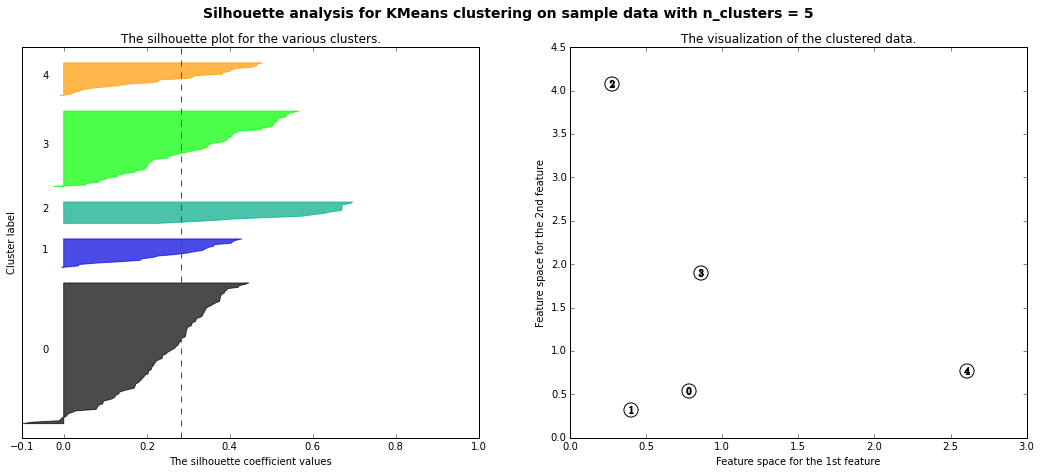

('For n_clusters =', 6, 'The average silhouette_score is :', 0.28626385292626849)


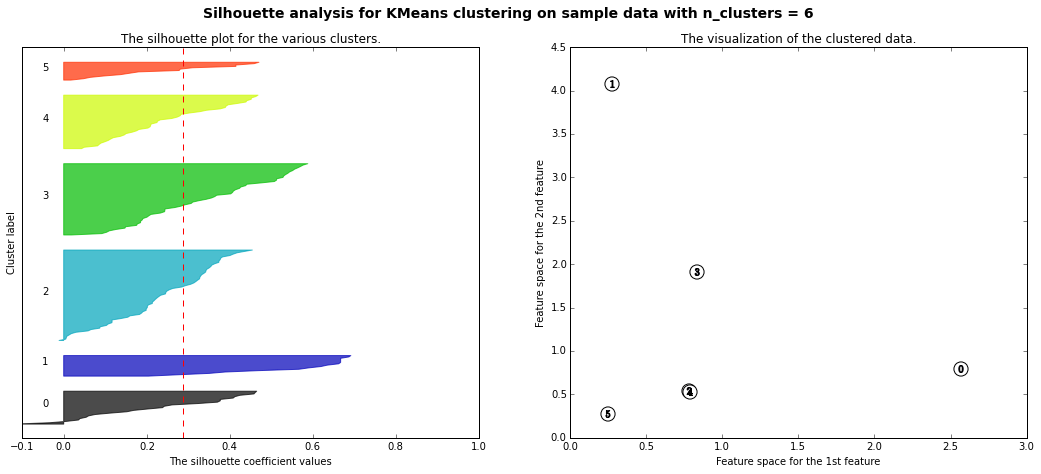

('For n_clusters =', 7, 'The average silhouette_score is :', 0.28463319312060181)


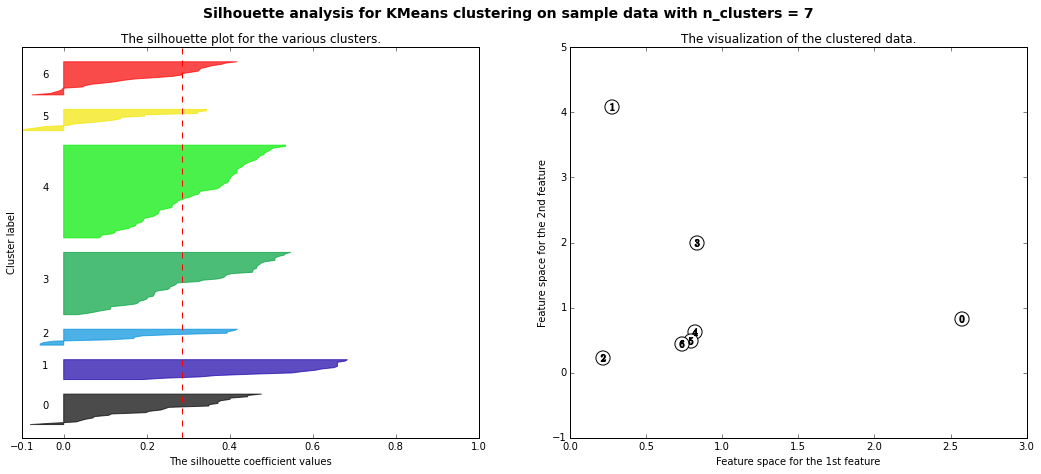

('For n_clusters =', 8, 'The average silhouette_score is :', 0.29195118443084311)


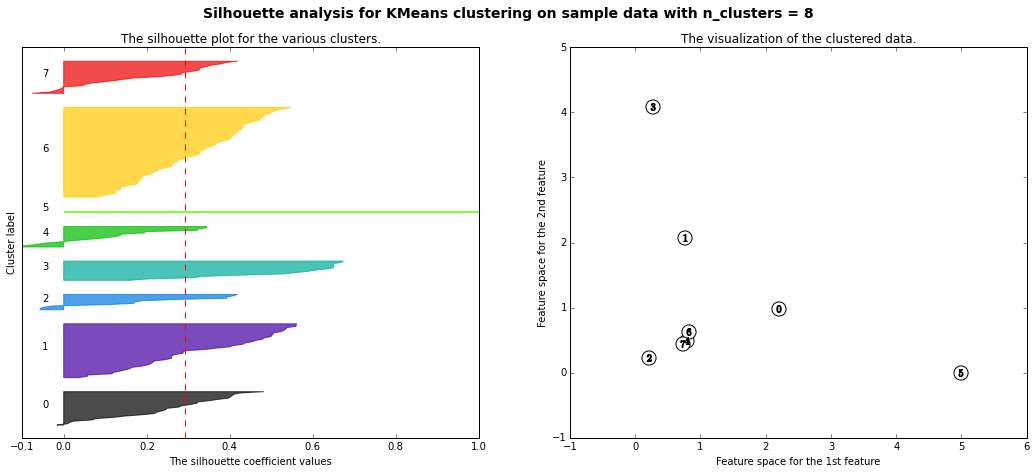

('For n_clusters =', 9, 'The average silhouette_score is :', 0.26104595271308051)


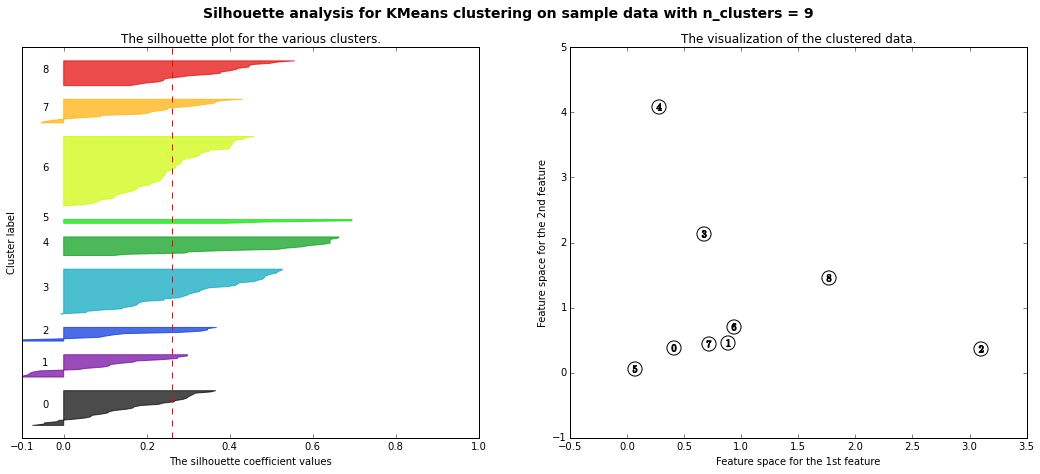

('For n_clusters =', 10, 'The average silhouette_score is :', 0.27768189958224904)


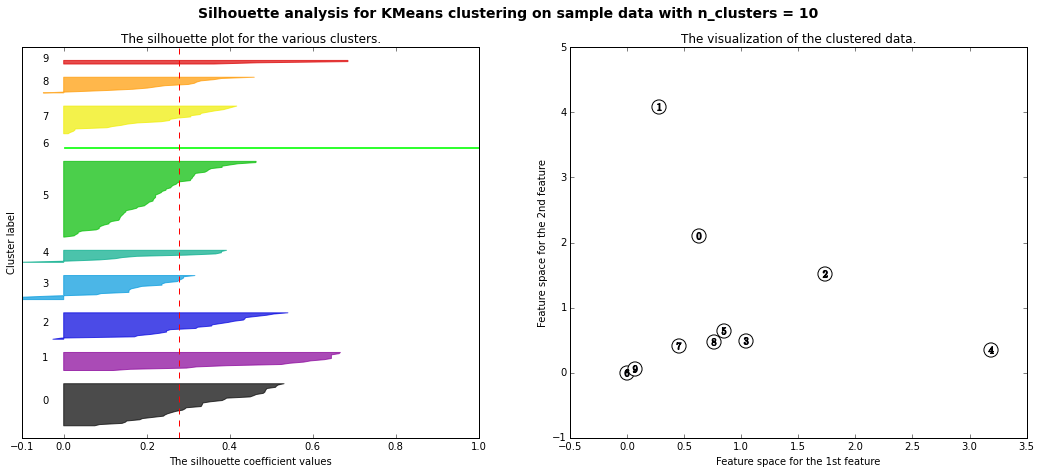

('For n_clusters =', 11, 'The average silhouette_score is :', 0.28207414278899423)


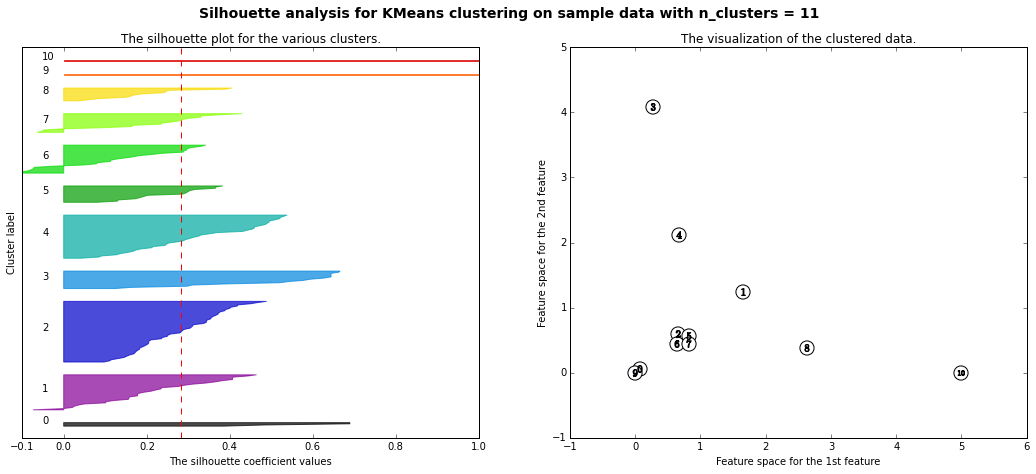

('For n_clusters =', 12, 'The average silhouette_score is :', 0.2827505436722707)


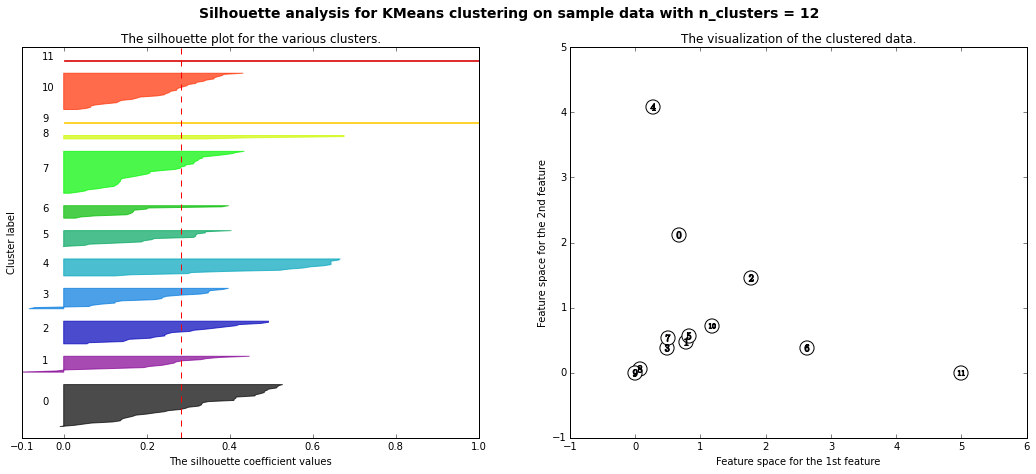

('For n_clusters =', 13, 'The average silhouette_score is :', 0.2740699884445742)


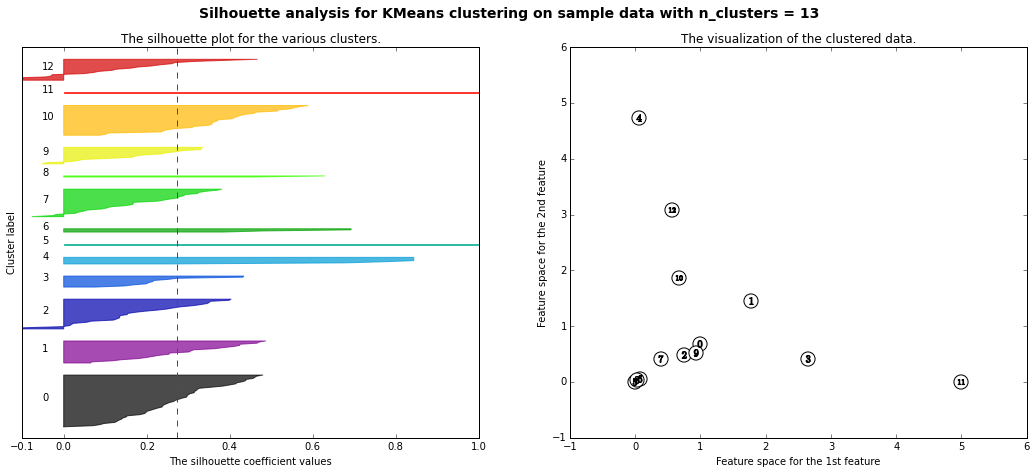

('For n_clusters =', 14, 'The average silhouette_score is :', 0.26820676425158552)


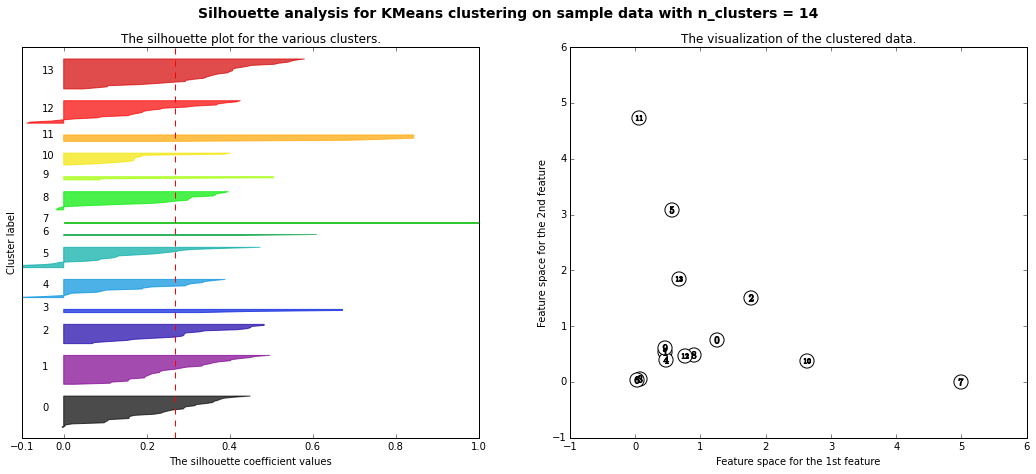

In [488]:
#Silhoette data to determine optimal number of clusters
silhoetteAnalysis(KO_limited_Norm2Mean, np.arange(5,15,1))

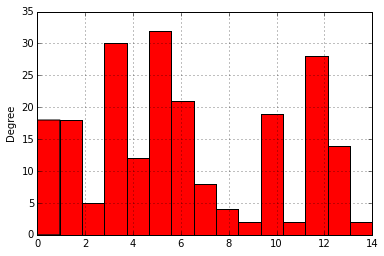

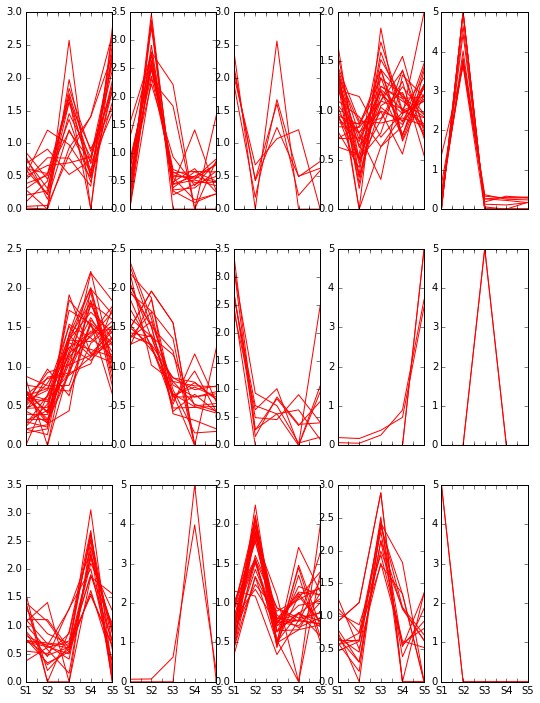

In [489]:
koClust=kmeanCluster(KO_limited_Norm2Mean, 15)
PlotKmeans(koClust,15,3,5, 'r') 

('For n_clusters =', 5, 'The average silhouette_score is :', 0.39026715851491639)


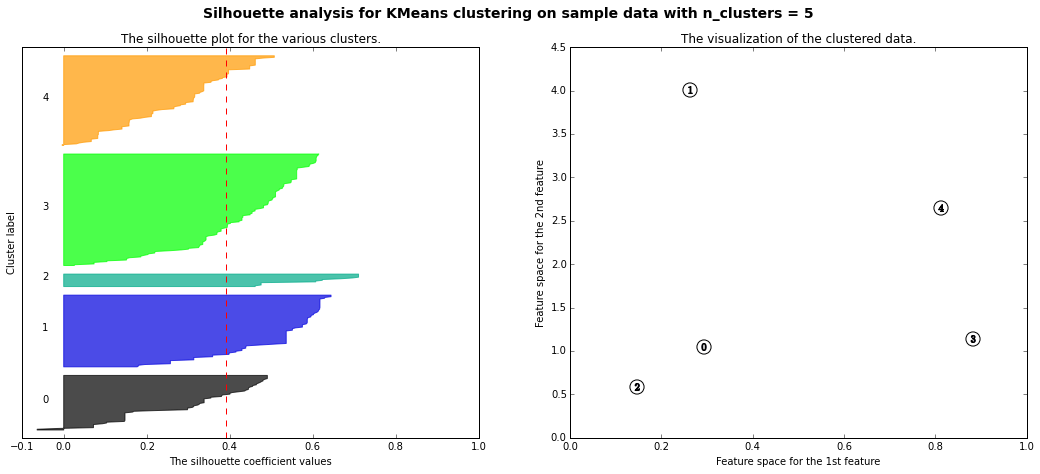

('For n_clusters =', 6, 'The average silhouette_score is :', 0.39951629248221365)


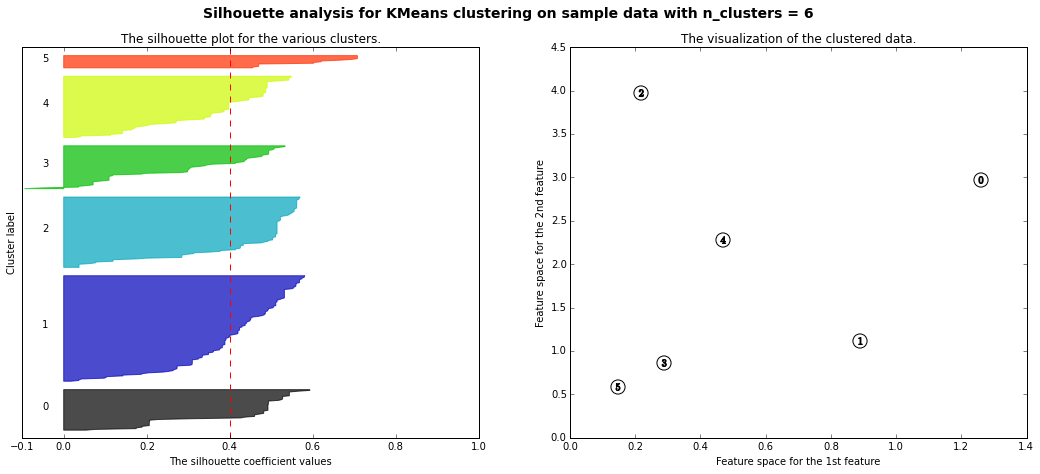

('For n_clusters =', 7, 'The average silhouette_score is :', 0.3666958788472941)


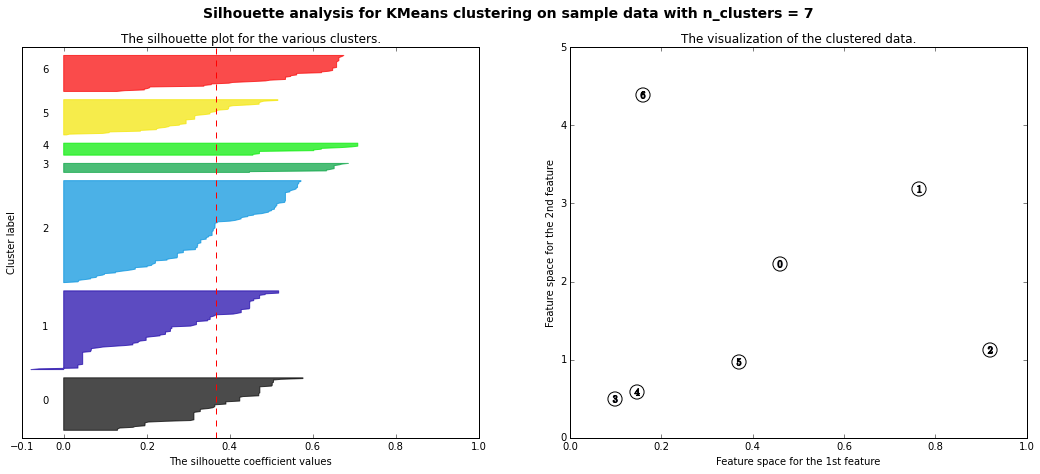

('For n_clusters =', 8, 'The average silhouette_score is :', 0.37207089298620671)


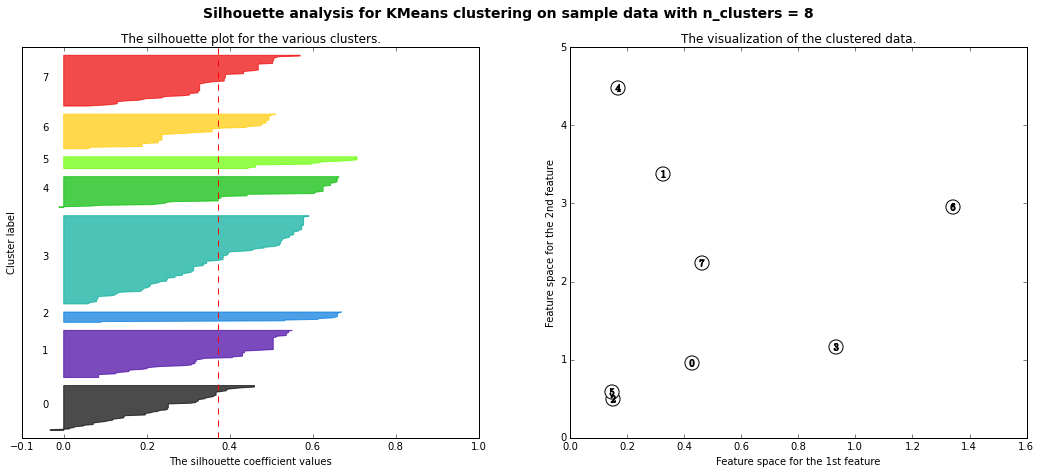

('For n_clusters =', 9, 'The average silhouette_score is :', 0.37610945336077312)


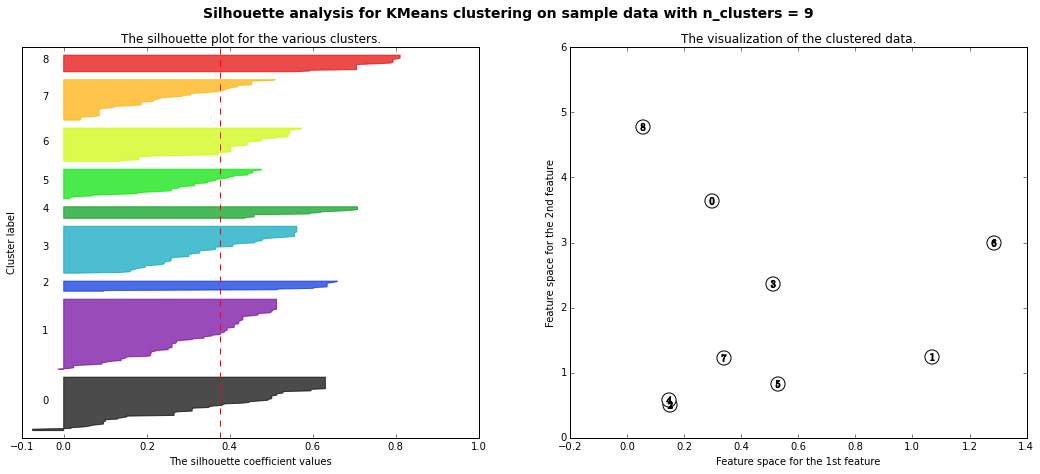

('For n_clusters =', 10, 'The average silhouette_score is :', 0.37200792325884341)


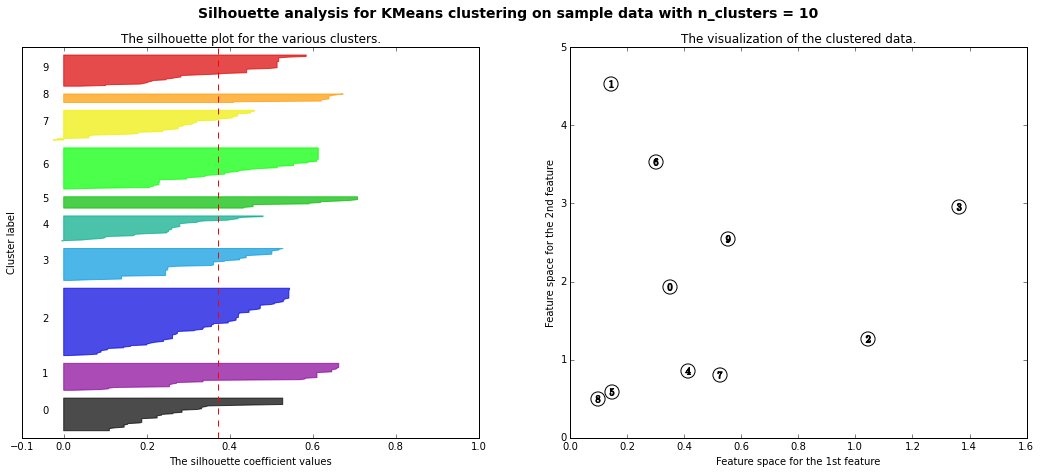

('For n_clusters =', 11, 'The average silhouette_score is :', 0.37669960664058172)


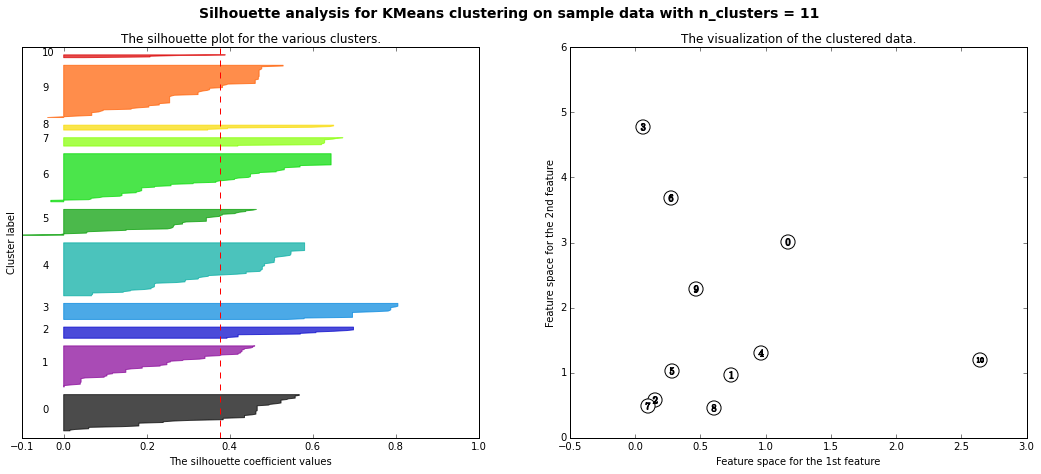

('For n_clusters =', 12, 'The average silhouette_score is :', 0.37681201019436583)


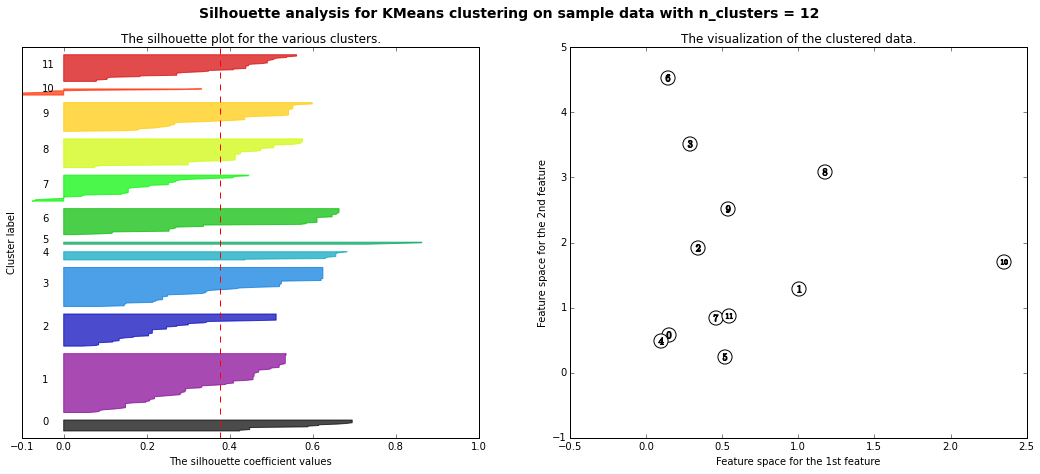

('For n_clusters =', 13, 'The average silhouette_score is :', 0.38118160495629388)


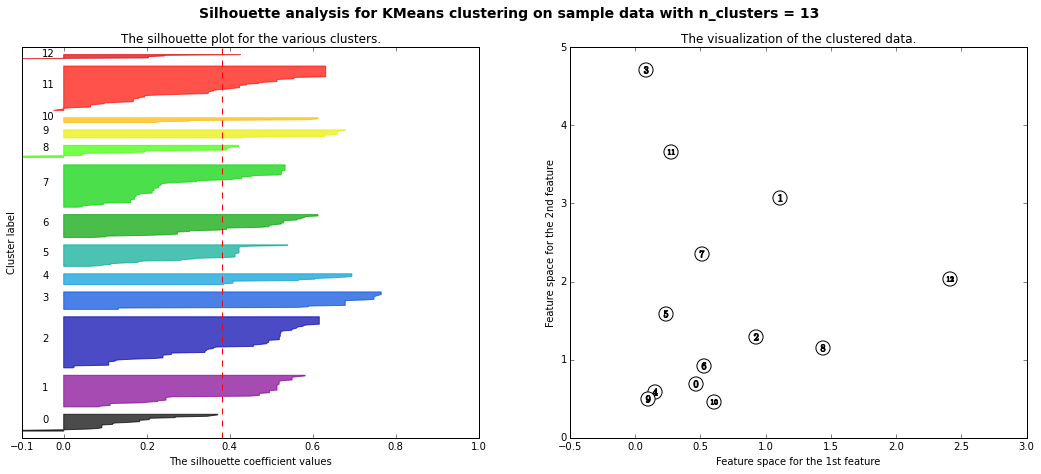

('For n_clusters =', 14, 'The average silhouette_score is :', 0.38238972906901464)


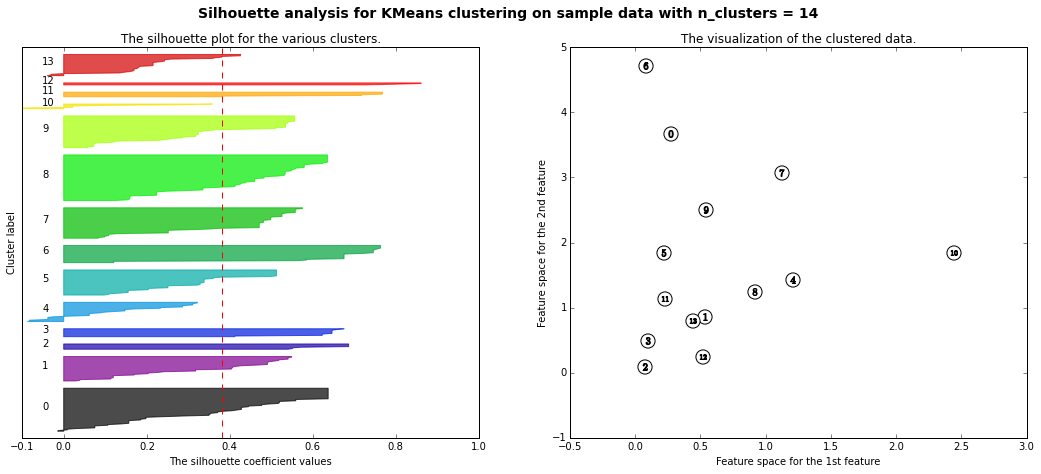

In [405]:
silhoetteAnalysis(CO_limited_Norm2Mean, np.arange(5,15,1))

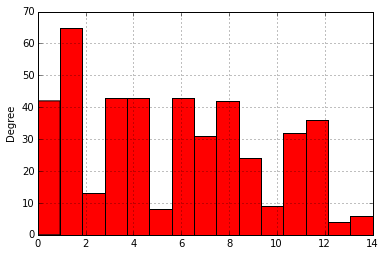

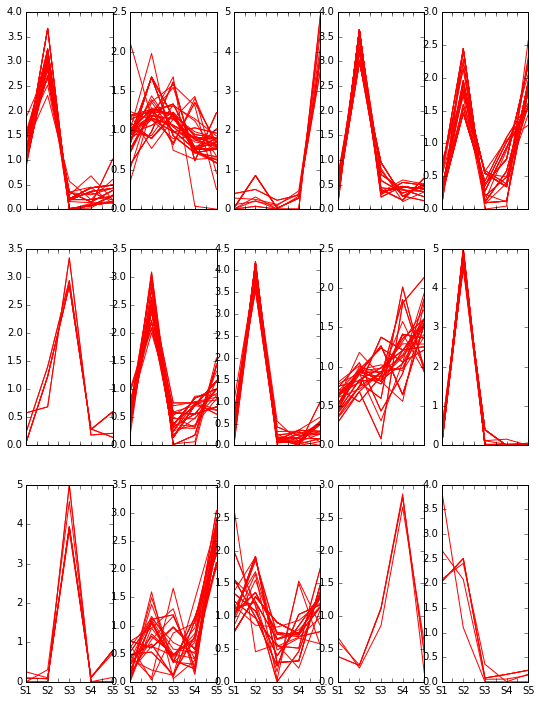

In [491]:
coClust=kmeanCluster(CO_limited_Norm2Mean, 15)
PlotKmeans(coClust,15,3,5, 'r') 

By normalizing the data to the mean we can then (in theory) combine the two and cluster them together? 

('For n_clusters =', 5, 'The average silhouette_score is :', 0.32870679250139351)


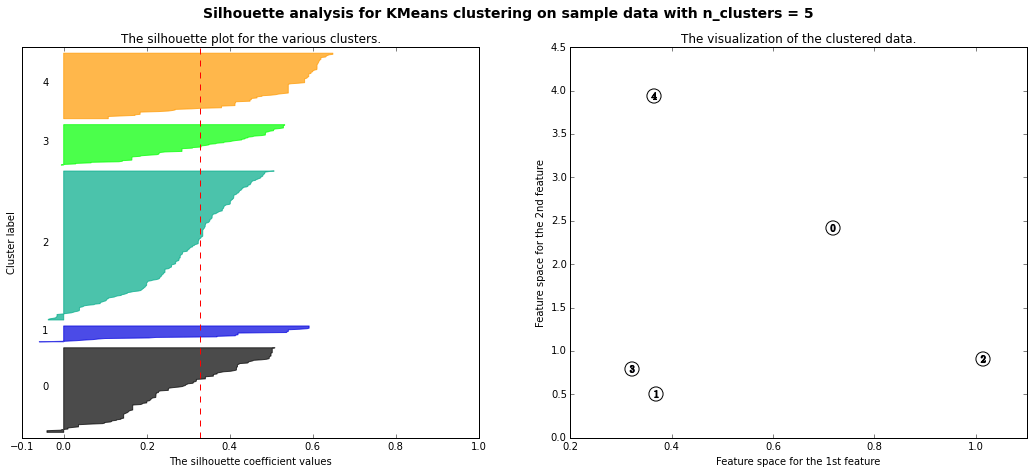

('For n_clusters =', 6, 'The average silhouette_score is :', 0.34580123284406356)


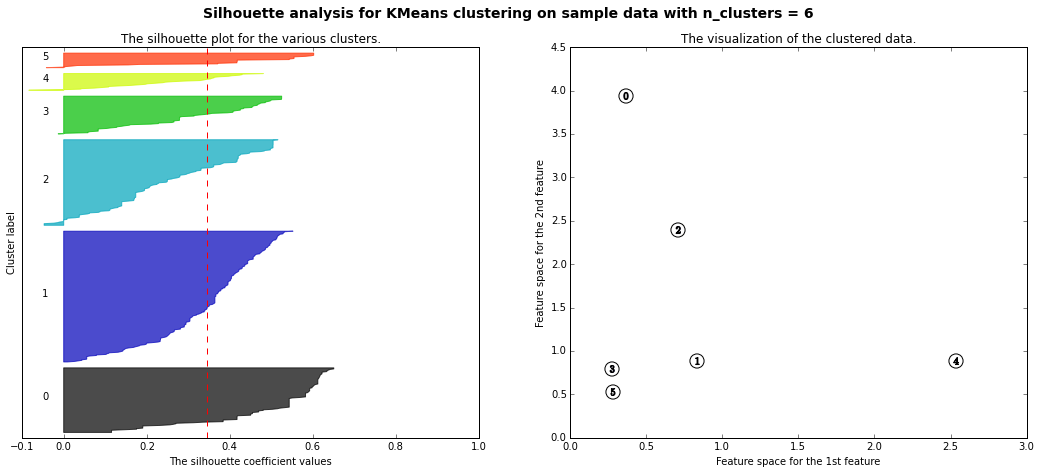

('For n_clusters =', 7, 'The average silhouette_score is :', 0.33538523974310958)


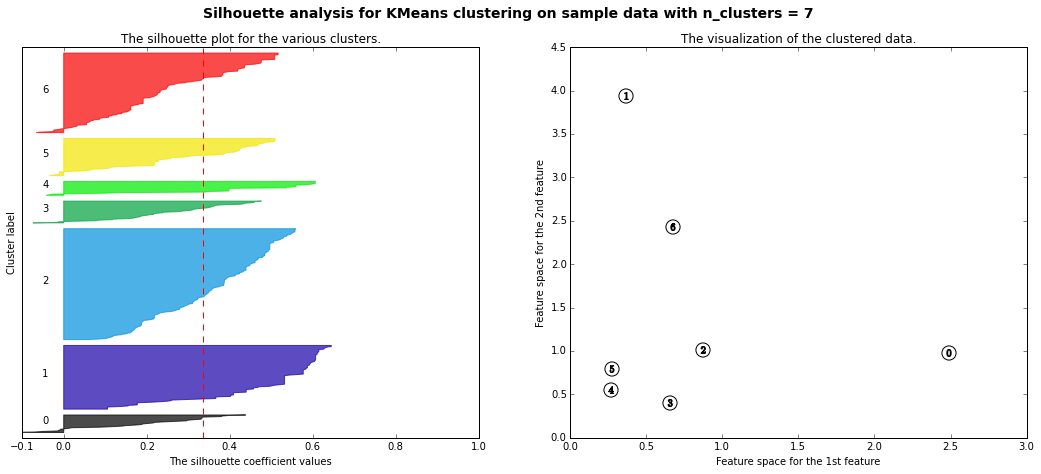

('For n_clusters =', 8, 'The average silhouette_score is :', 0.31619291302493963)


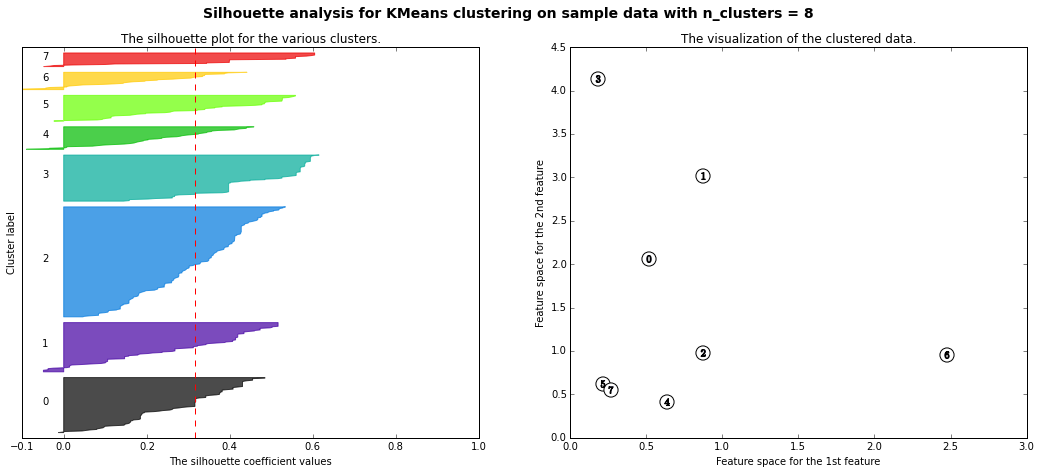

('For n_clusters =', 9, 'The average silhouette_score is :', 0.31131952928693951)


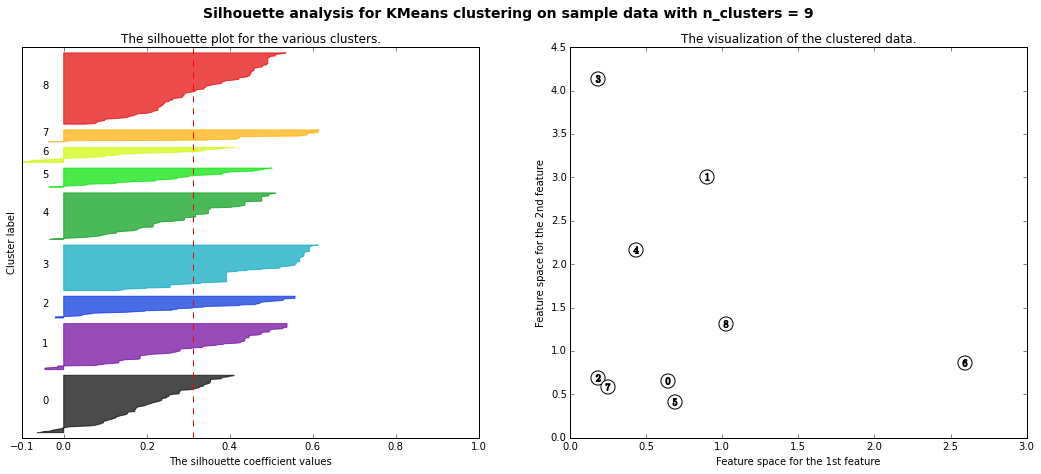

('For n_clusters =', 10, 'The average silhouette_score is :', 0.311633195584818)


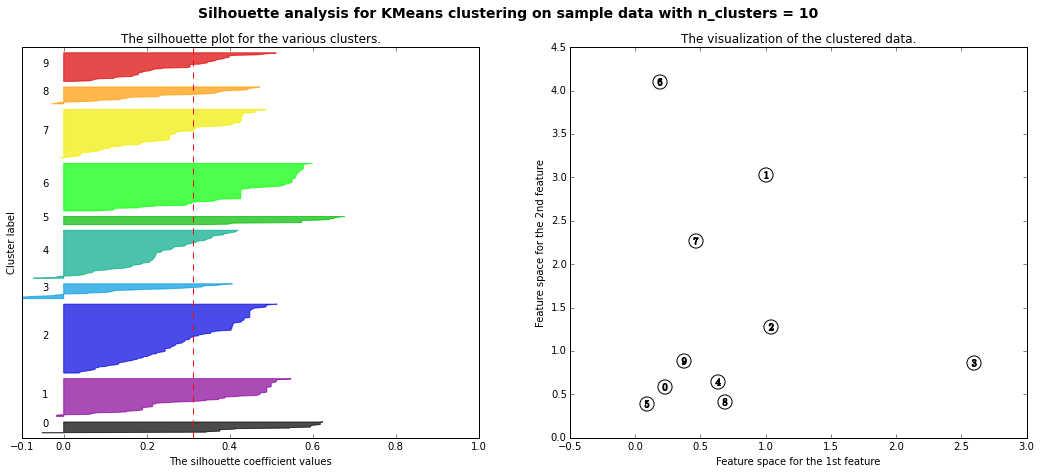

('For n_clusters =', 11, 'The average silhouette_score is :', 0.31674177317596885)


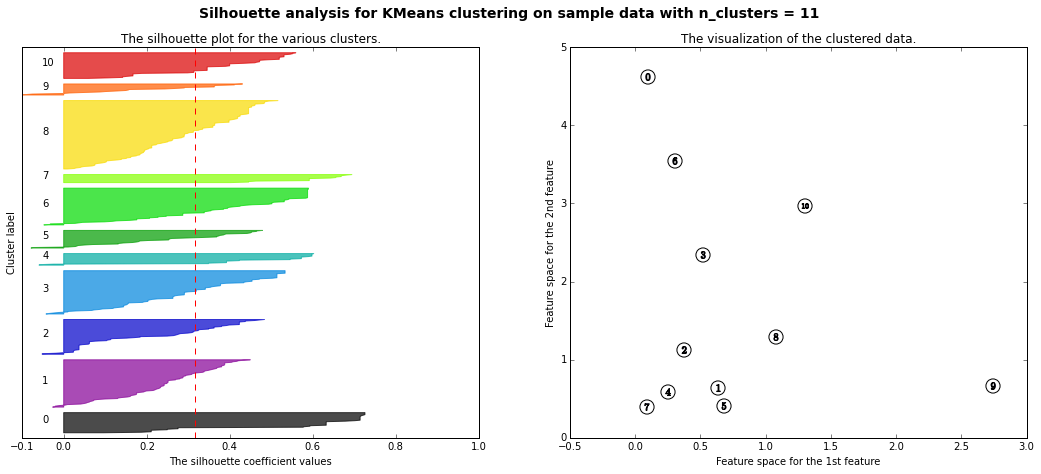

('For n_clusters =', 12, 'The average silhouette_score is :', 0.32255116993884431)


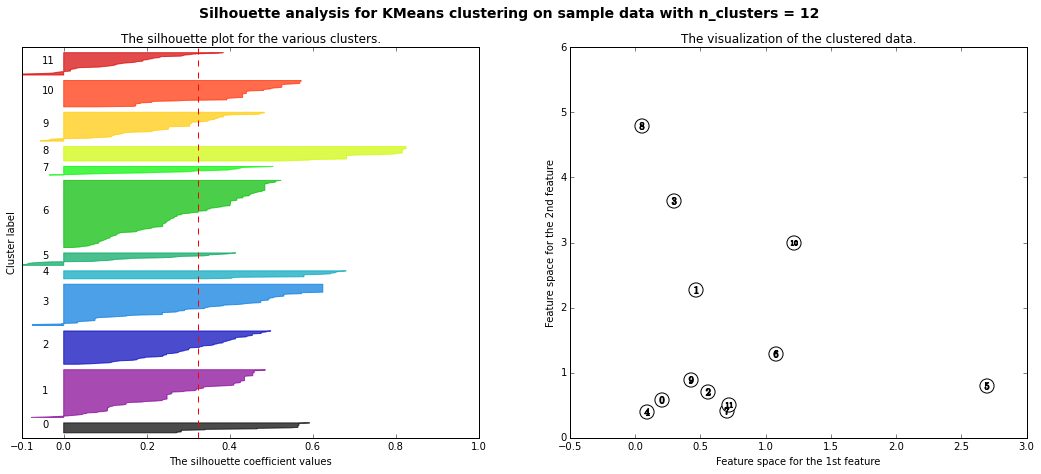

('For n_clusters =', 13, 'The average silhouette_score is :', 0.3148185871465945)


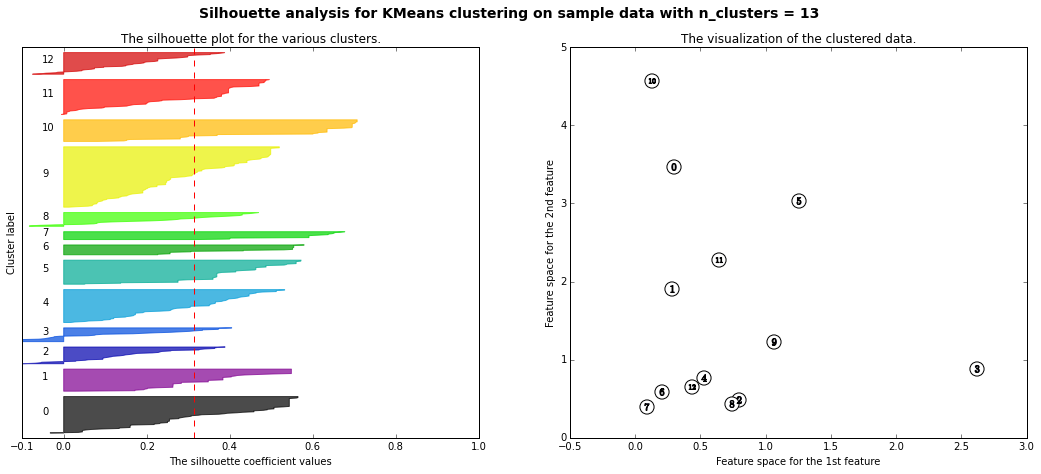

('For n_clusters =', 14, 'The average silhouette_score is :', 0.31852958034740536)


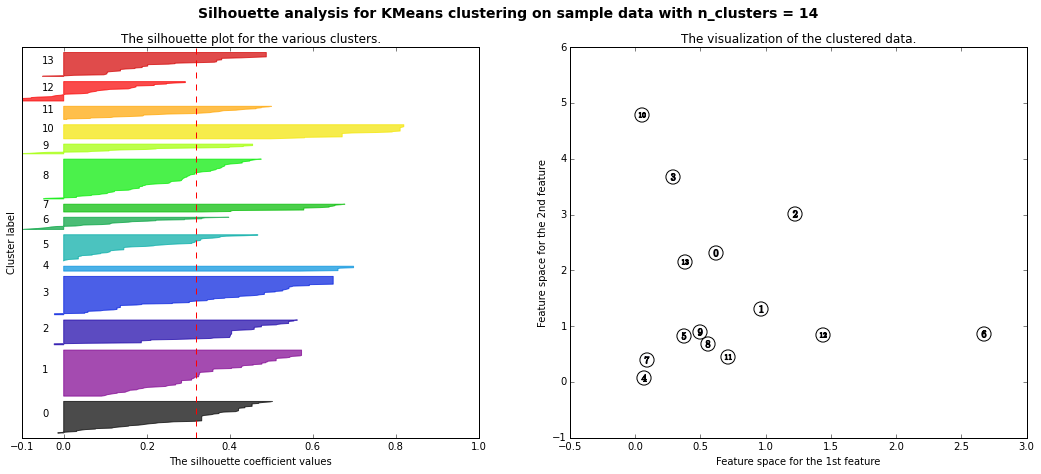

('For n_clusters =', 15, 'The average silhouette_score is :', 0.31446042530746265)


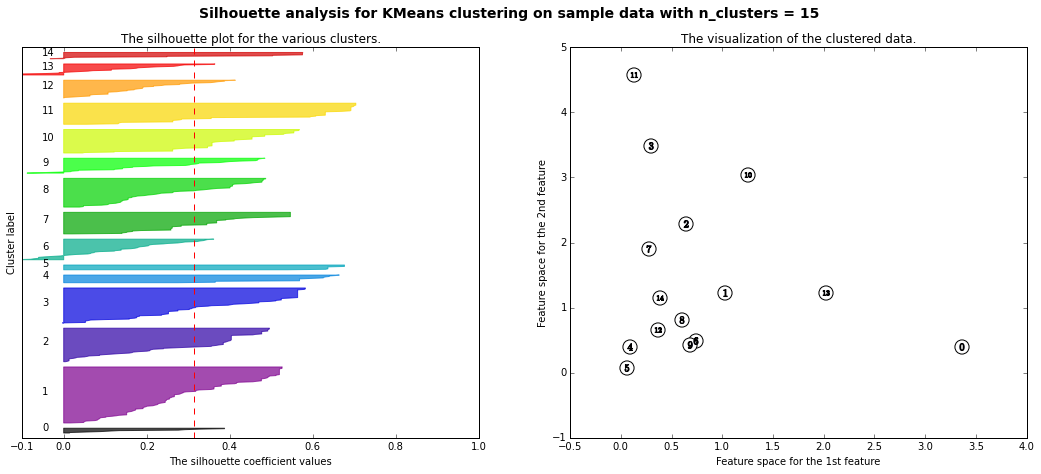

('For n_clusters =', 16, 'The average silhouette_score is :', 0.32224556555584161)


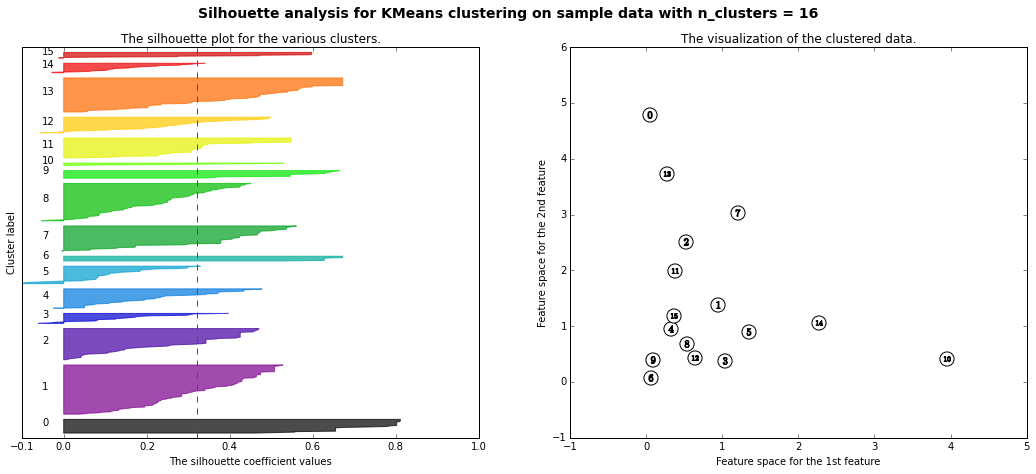

('For n_clusters =', 17, 'The average silhouette_score is :', 0.31557824751953945)


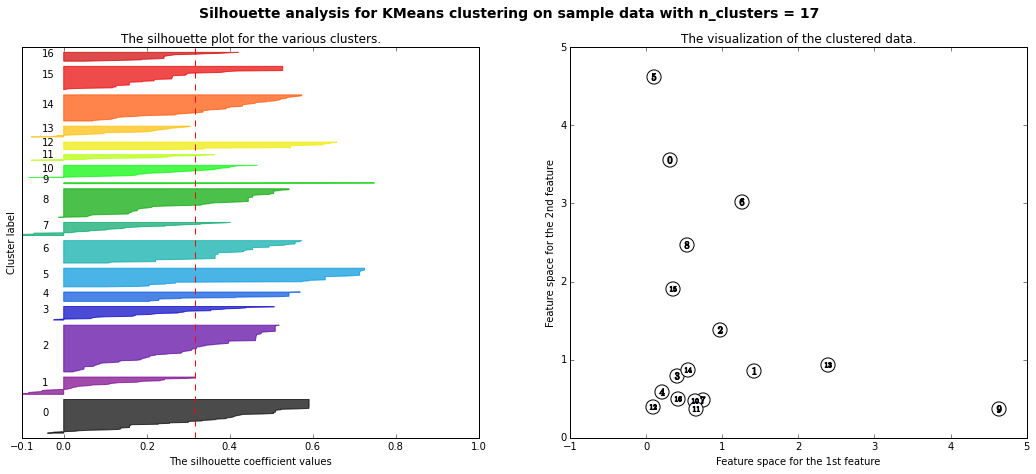

('For n_clusters =', 18, 'The average silhouette_score is :', 0.30935302399530556)


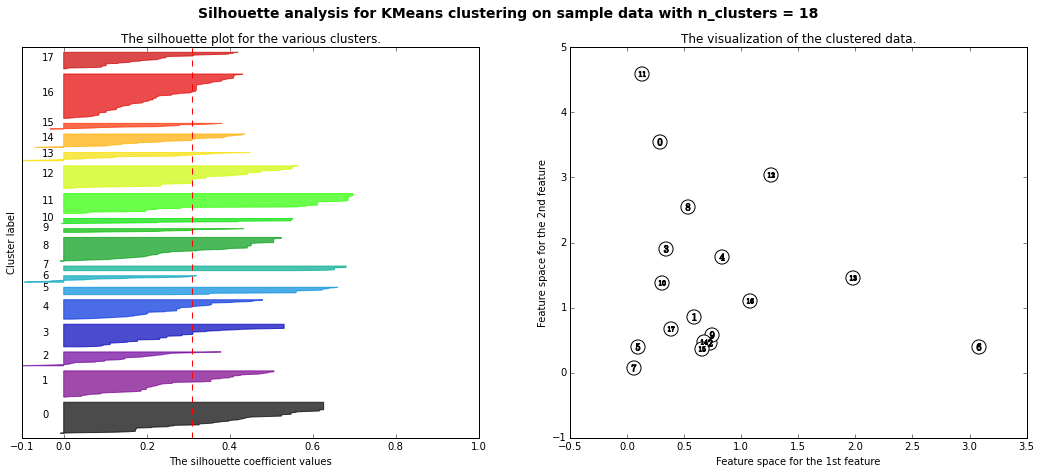

('For n_clusters =', 19, 'The average silhouette_score is :', 0.29894668033127403)


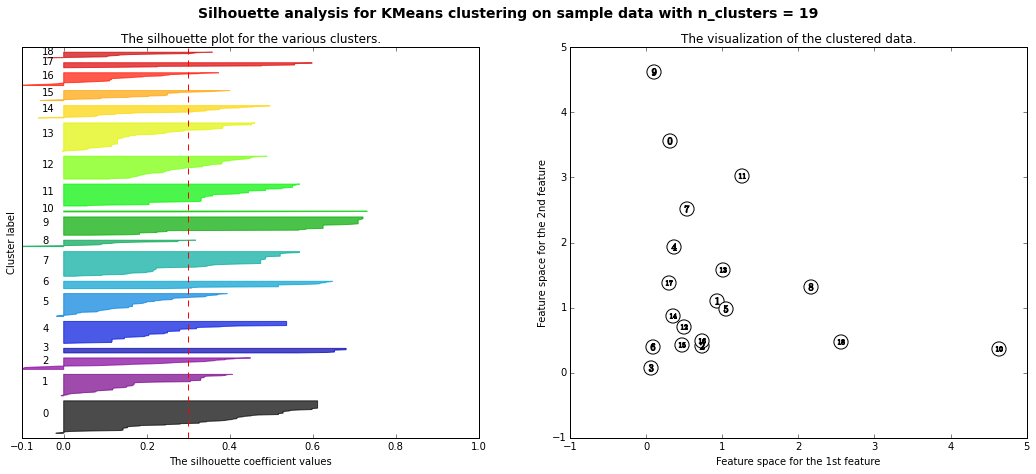

In [490]:
Combined_KO_CO_MeanNorm=KO_limited_Norm2Mean.append(CO_limited_Norm2Mean)
# Combined_KO_CO_MeanNorm=Combined_KO_CO_MeanNorm-Combined_KO_CO_MeanNorm.mean()
#Run silhoette analysis
silhoetteAnalysis(Combined_KO_CO_MeanNorm, np.arange(5,20,1))

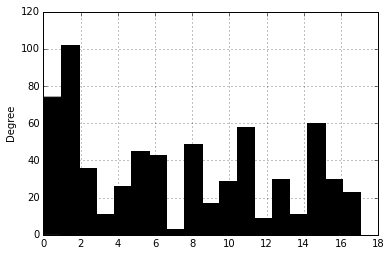

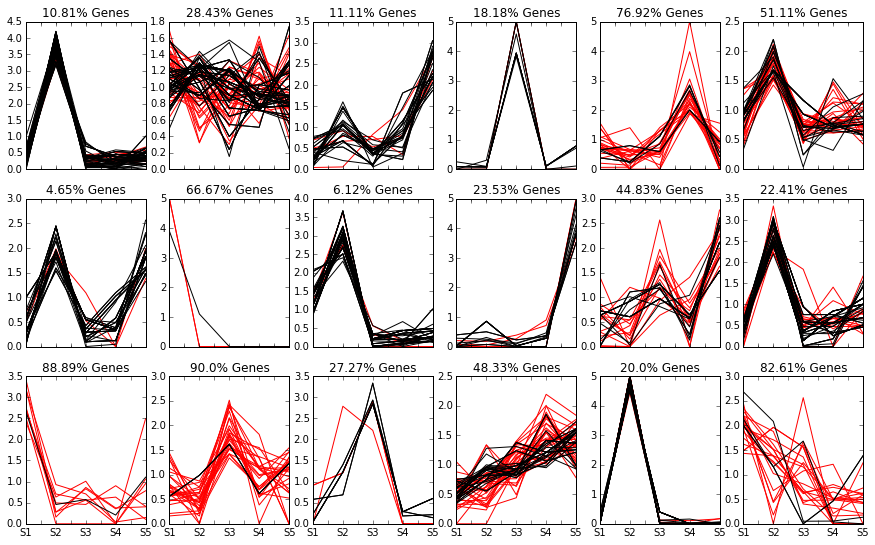

In [498]:
def PlotKmeansCombined(KmeansPD, kSize=10, figSizeX=1, figSizeY=5, color='k'):
    KmeansPD['kmeans'].plot(kind='hist', bins=kSize, color='k')
    fig,axs=plt.subplots(figSizeX, figSizeY)
    axs=[item for sublist in axs for item in sublist]
    fig.set_size_inches(15,9)
    i=KmeansPD.index
    i=list(i)
    Ks=re.compile('K.*')
    Cs=re.compile('C.*')
    C = filter(Cs.search, i)  
    K = filter(Ks.search, i)  
    Ksplit=KmeansPD.loc[K]
    Csplit=KmeansPD.loc[C]
    for ax, y in zip(axs,range(kSize)):
        KData=Ksplit[Ksplit.kmeans==y].T.drop('kmeans')
        KData.plot(ax=ax, legend=False, grid=False, color='r')
        CData=Csplit[Csplit.kmeans==y].T.drop('kmeans')
        CData.plot(ax=ax, legend=False, grid=False, color='k')
        SumKC=len(KData.T)+len(CData.T)
        KPct=float(len(KData.T))/SumKC*100
        CPct=float(len(CData.T))/SumKC*100
        ax.set_title(str(round(KPct,2))+'% Genes')
    
CcoClust=kmeanCluster(Combined_KO_CO_MeanNorm, 18)
PlotKmeansCombined(CcoClust,18,3,6, 'r') 


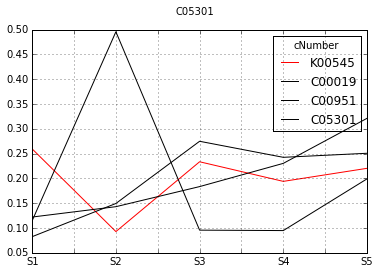

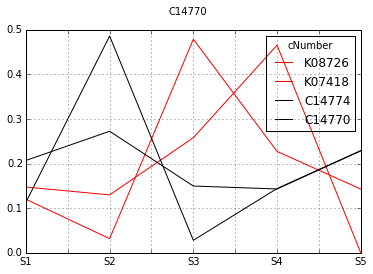

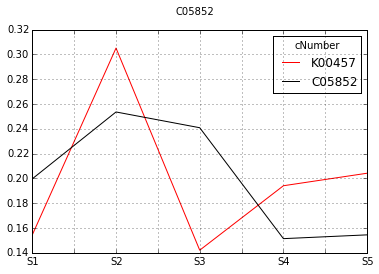

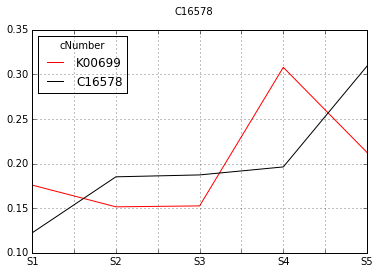

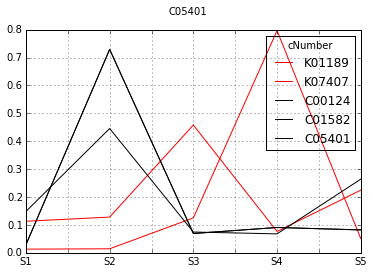

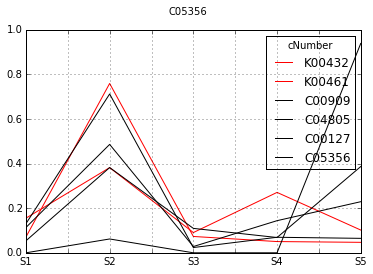

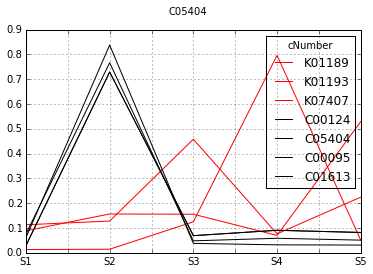

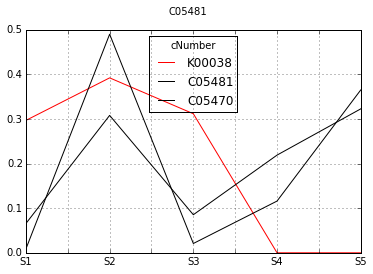

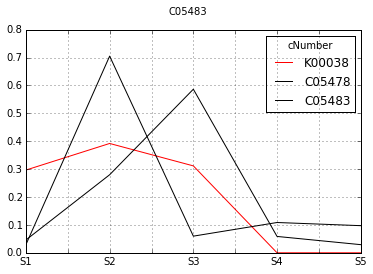

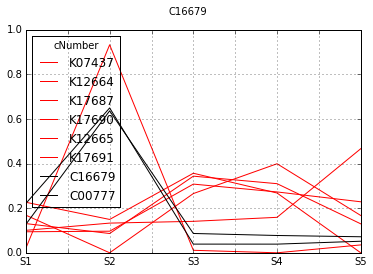

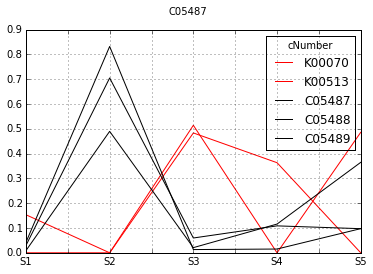

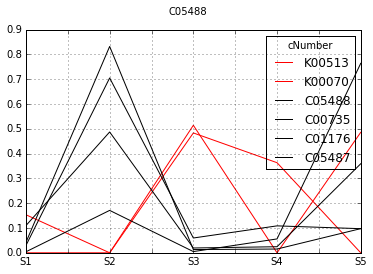

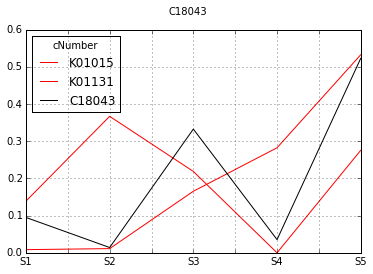

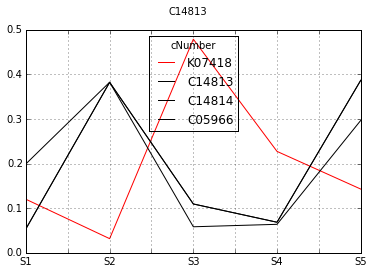

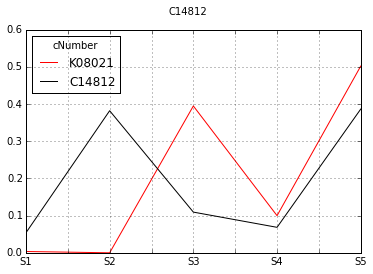

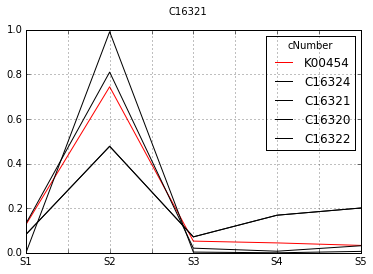

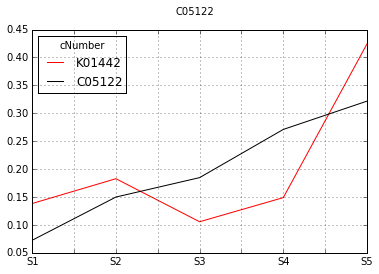

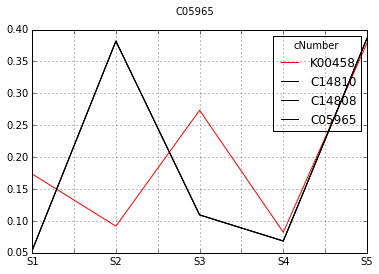

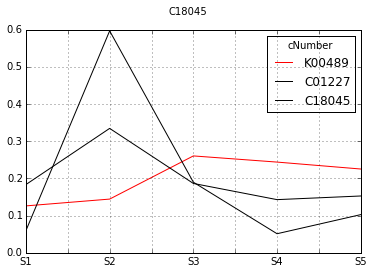

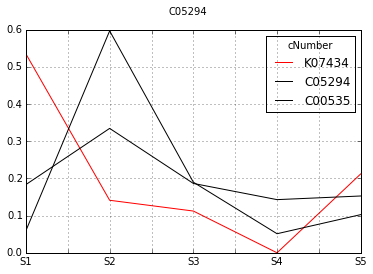

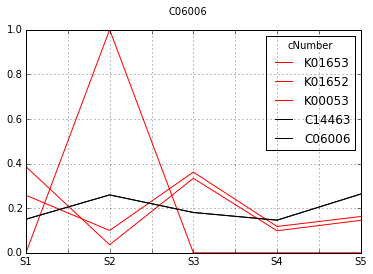

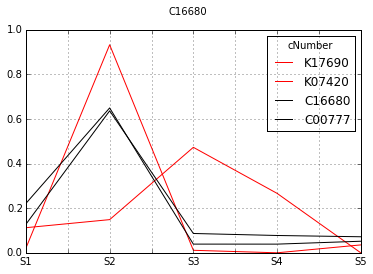

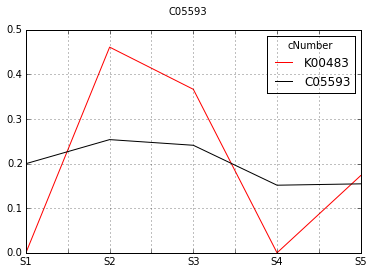

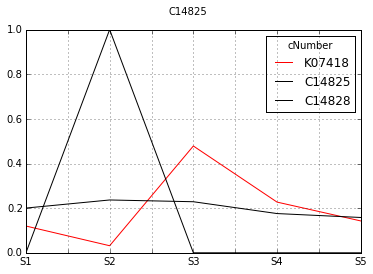

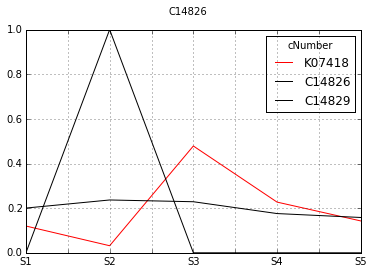

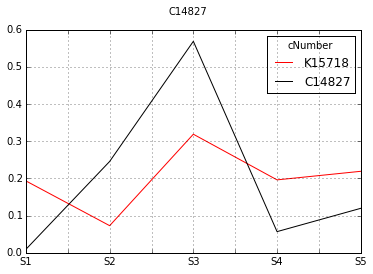

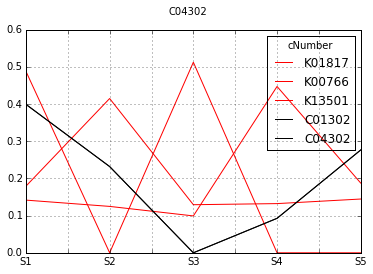

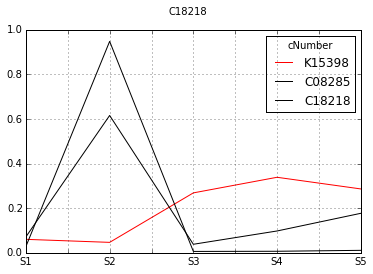

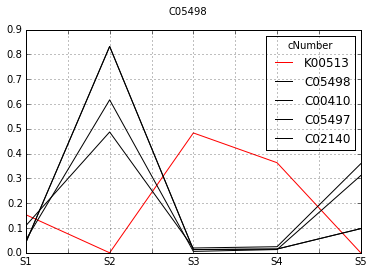

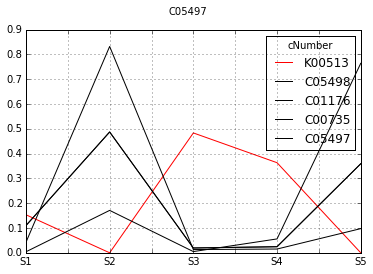

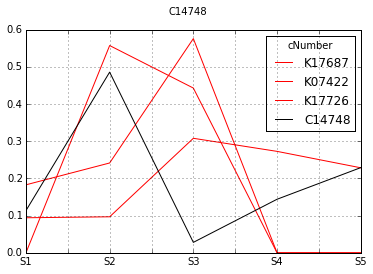

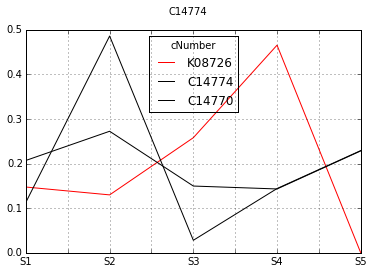

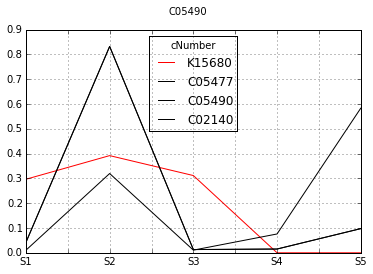

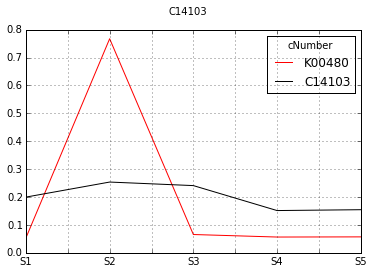

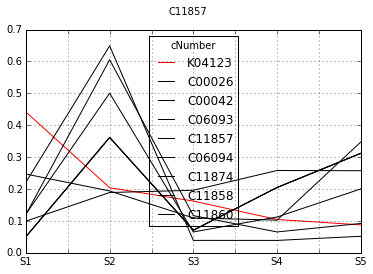

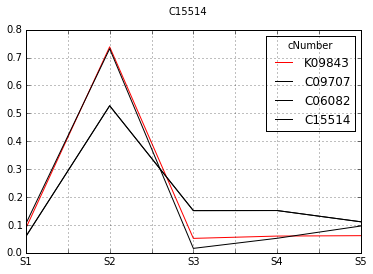

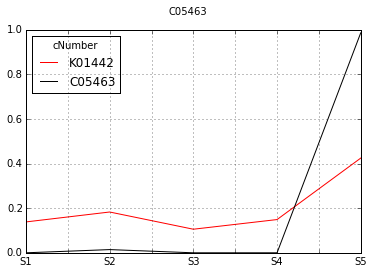

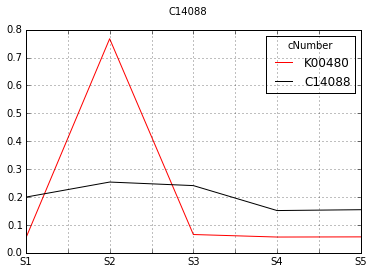

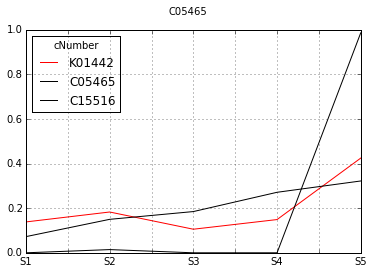

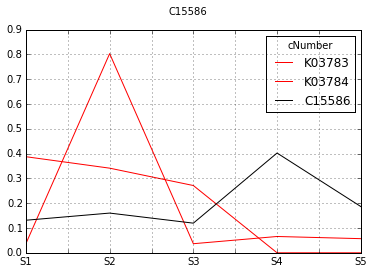

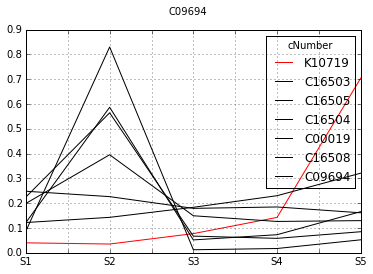

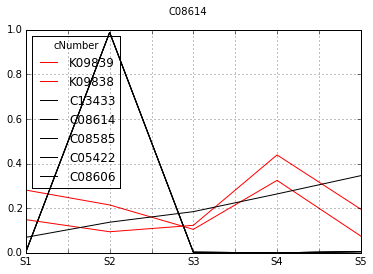

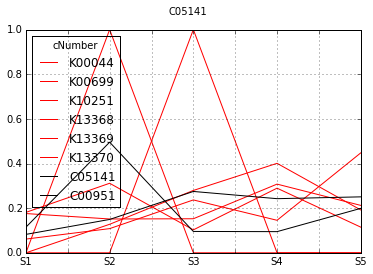

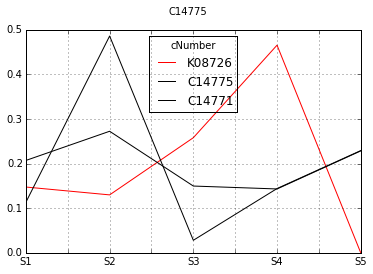

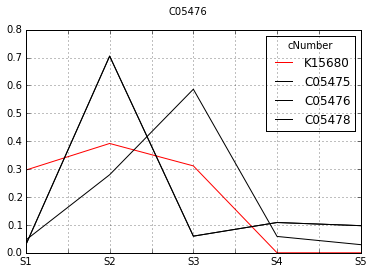

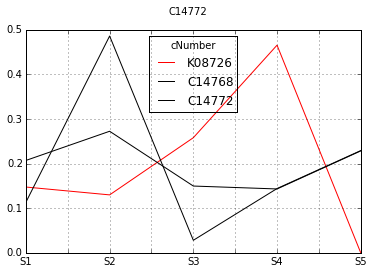

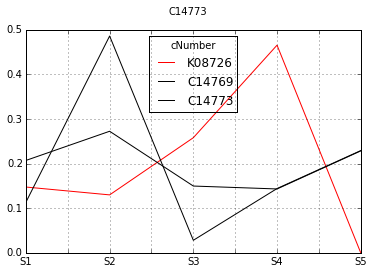

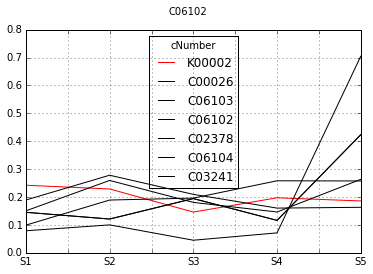

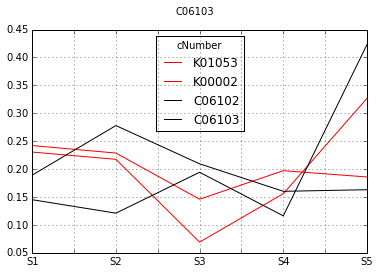

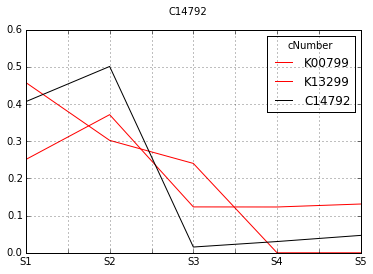

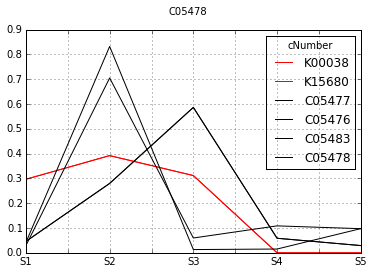

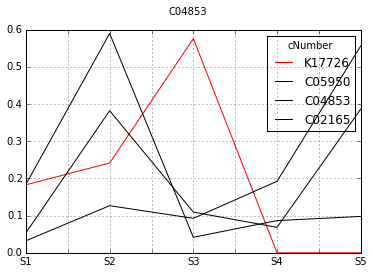

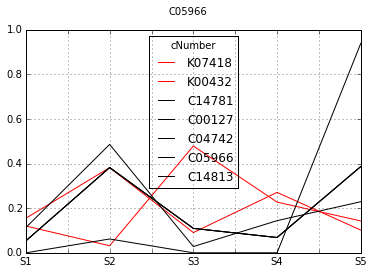

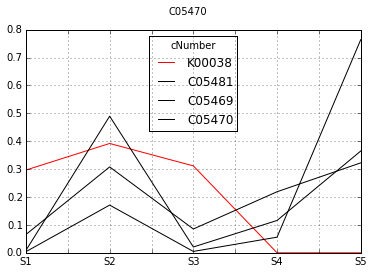

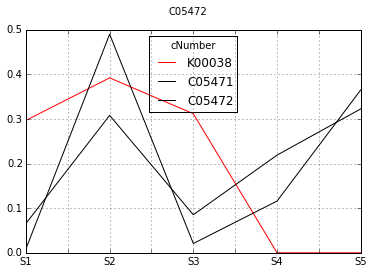

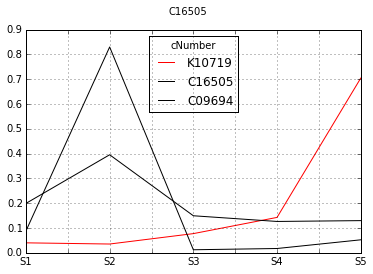

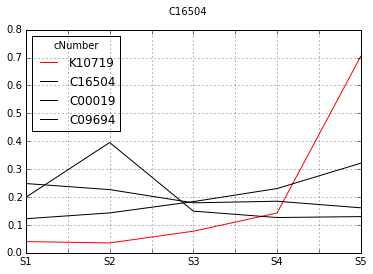

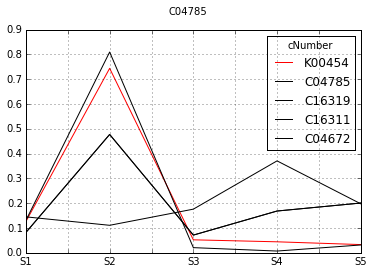

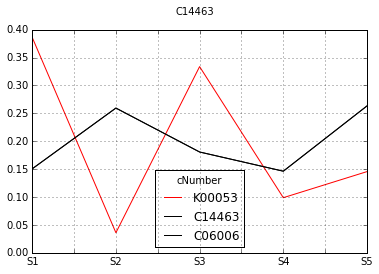

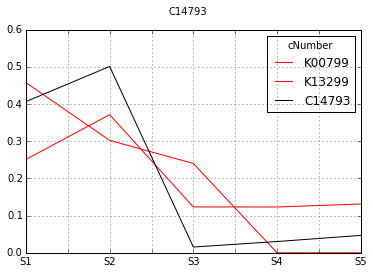

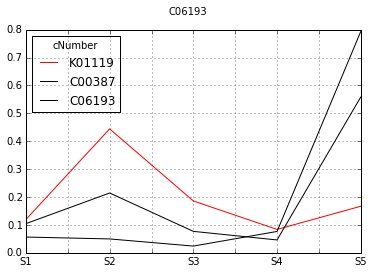

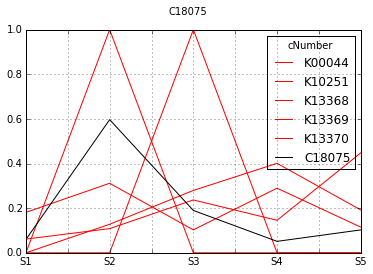

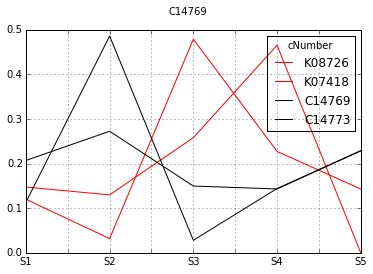

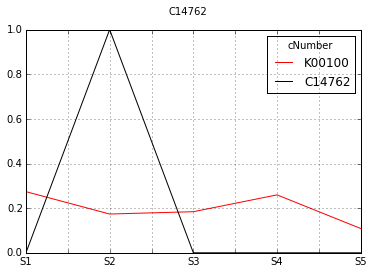

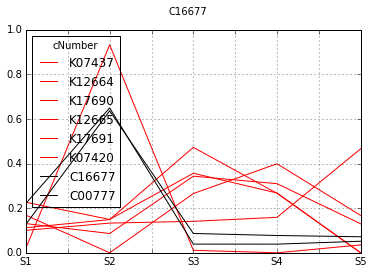

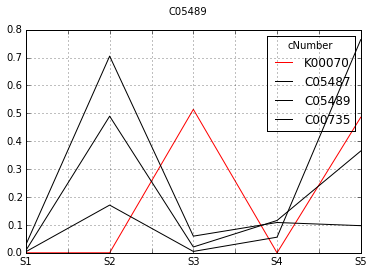

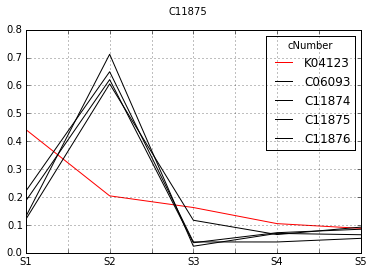

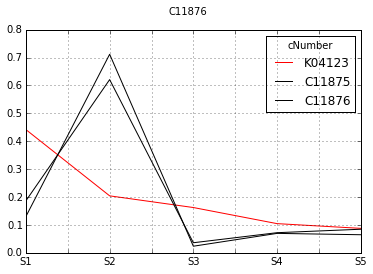

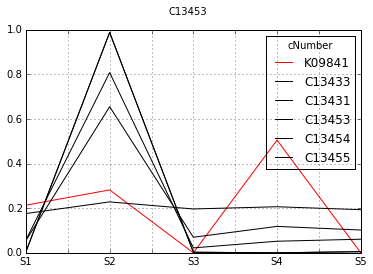

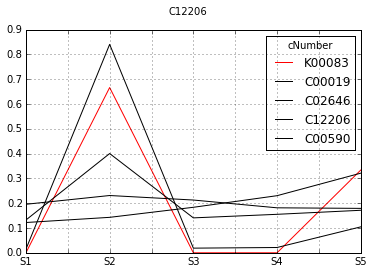

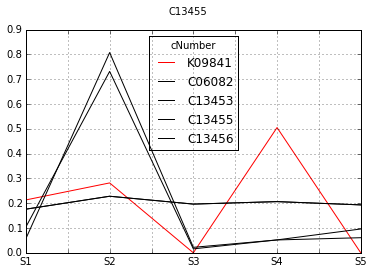

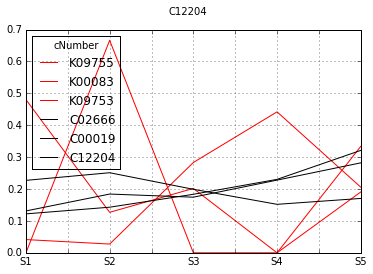

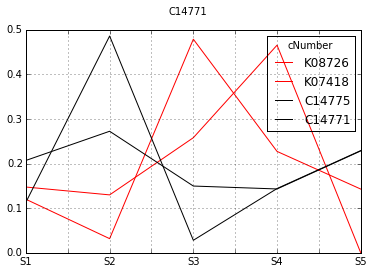

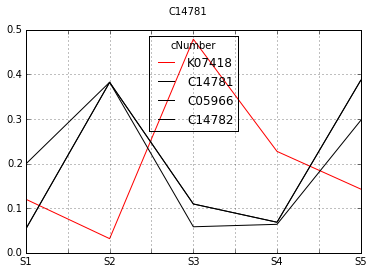

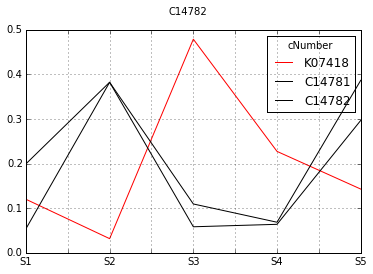

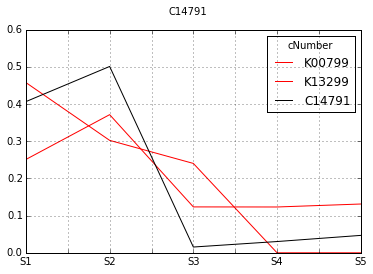

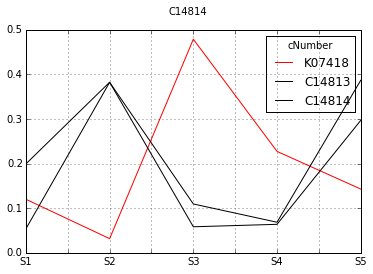

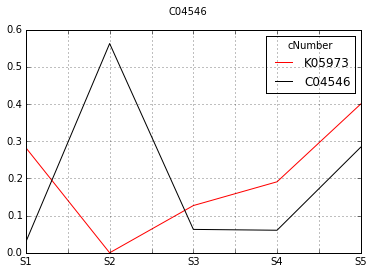

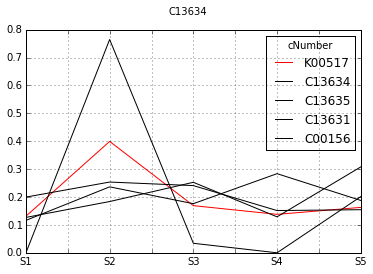

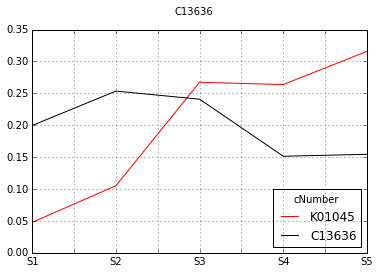

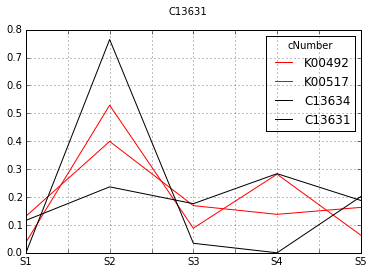

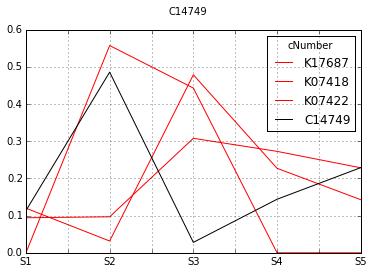

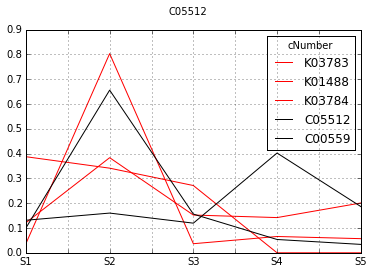

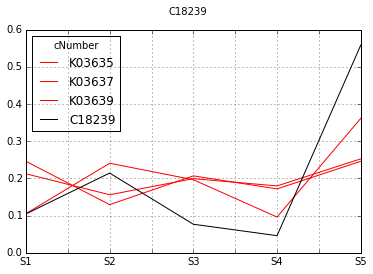

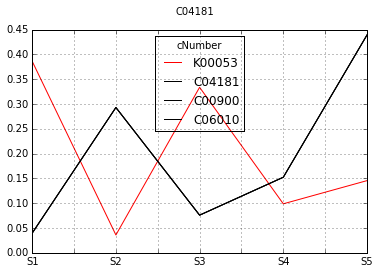

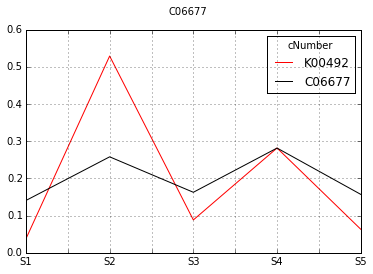

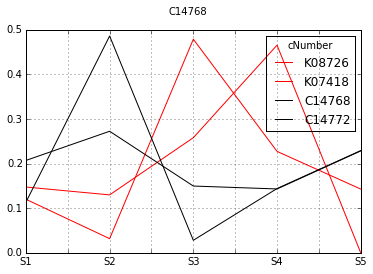

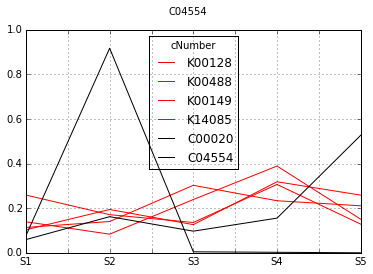

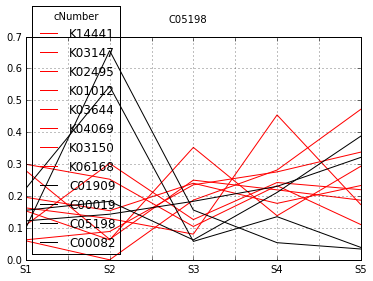

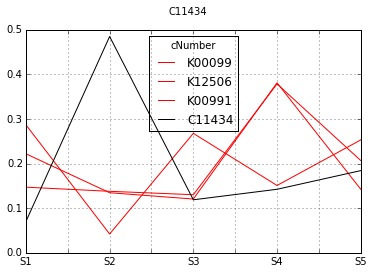

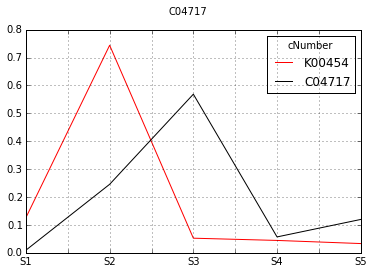

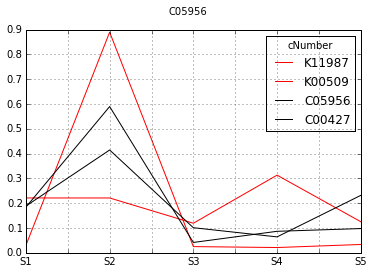

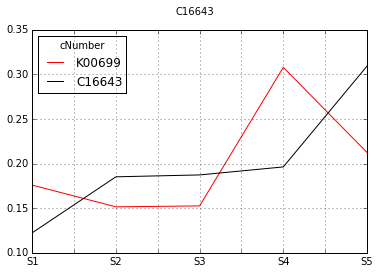

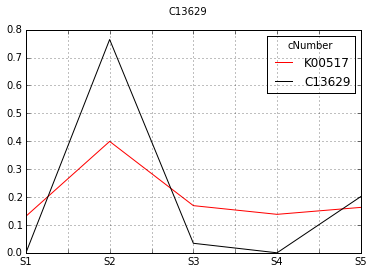

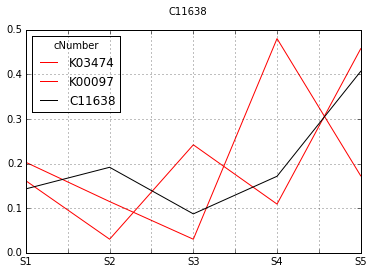

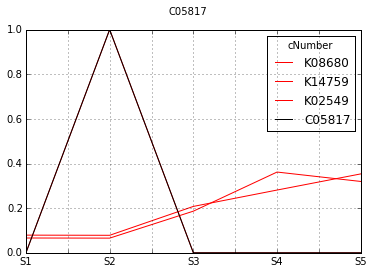

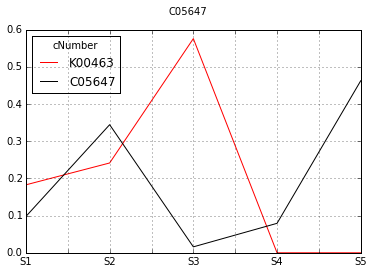

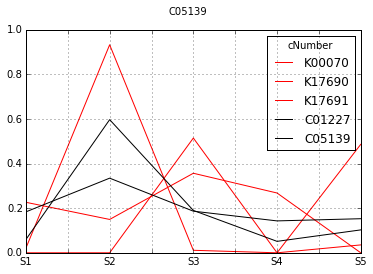

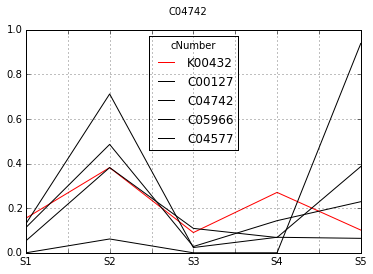

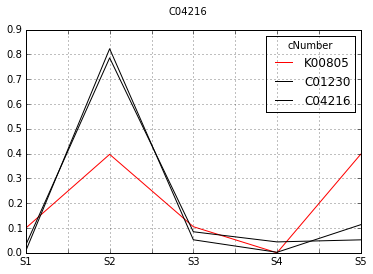

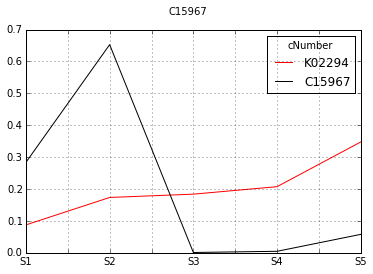

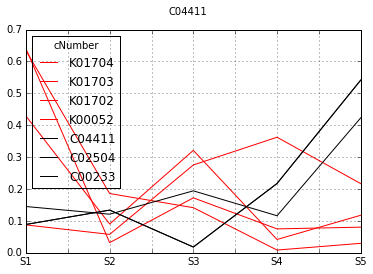

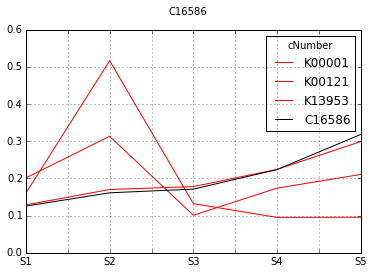

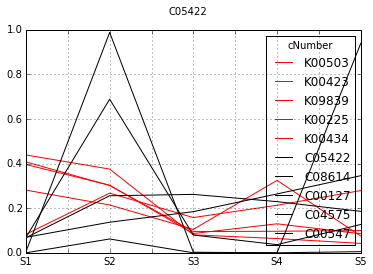

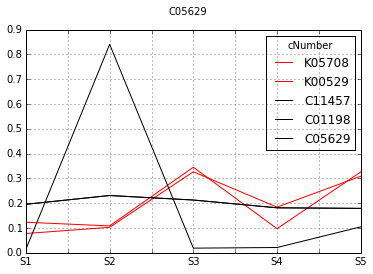

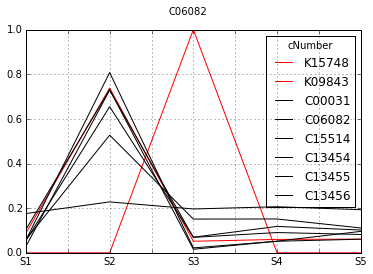

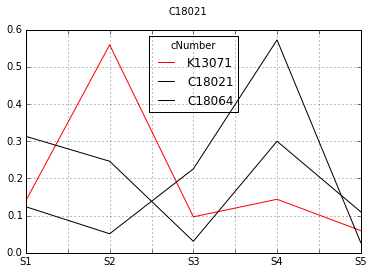

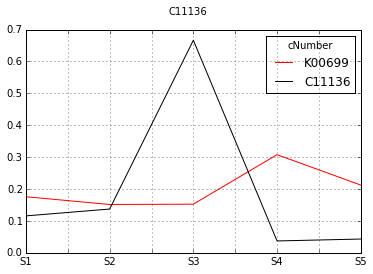

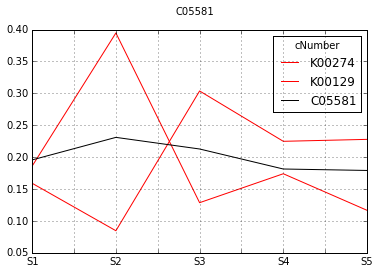

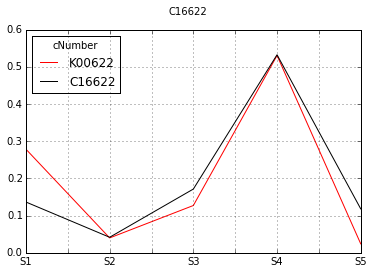

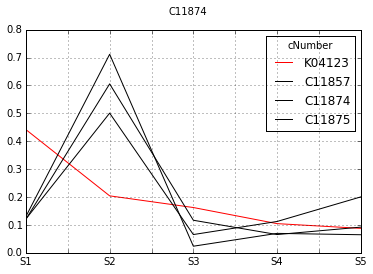

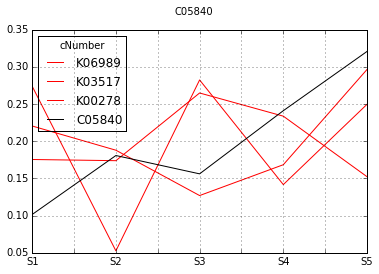

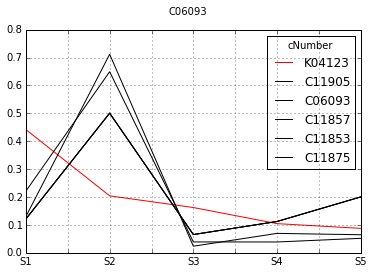

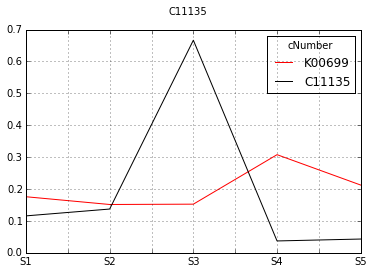

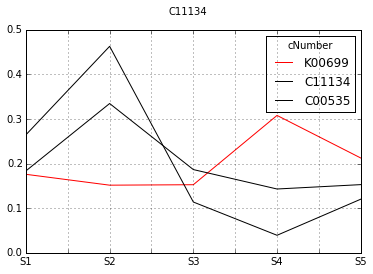

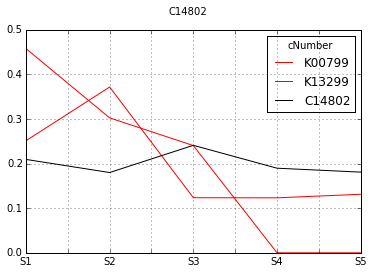

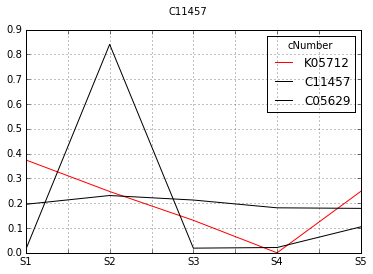

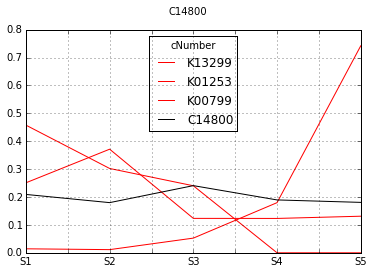

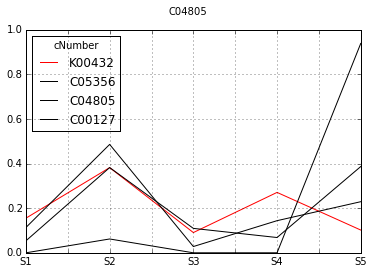

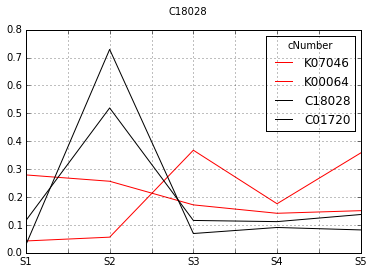

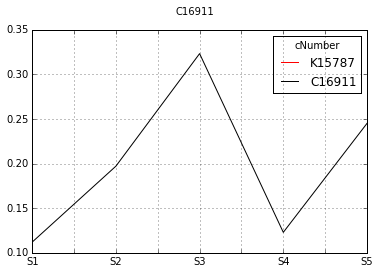

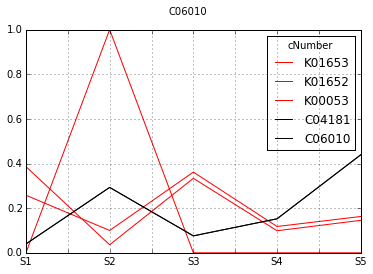

In [128]:
for i, CO in enumerate(CO_withKO):
#     if i==20:
#         break
    kos=CO_withKO[CO]['Related KO']
    cos=CO_withKO[CO]['Related CO']
    for k in kos: 
        if k in KO_RawData.index: 
            kData=KO_RawData.loc[kos].dropna()
            kData=(kData.T/kData.sum(axis=1)).T
            cData=CO_RawData.loc[cos].dropna()
            cData=(cData.T/cData.sum(axis=1)).T

            fig, ax=plt.subplots(1)
            kData.T.plot(color='r', ax=ax)
            cData.T.plot(color='k', ax=ax)
            fig.suptitle(CO)
            fig.savefig(CO+'.png')
            break
            

In [48]:
KO_RawData=KO_RawData[KO_RawData.sum(axis=1)!=0]
newData=((KO_RawData.T/(KO_RawData.T.mean()))).T
newData=newData-newData.mean()
kmeans=KMeans(n_clusters=15)

In [49]:
KO_RawData=KO_RawData[KO_RawData.sum(axis=1)!=0]
newData=((KO_RawData.T/(KO_RawData.T.mean()))).T
newData=newData-newData.mean()
kmeans=KMeans(n_clusters=15)


kmeans.fit(newData)

newData['kmeans']=kmeans.labels_

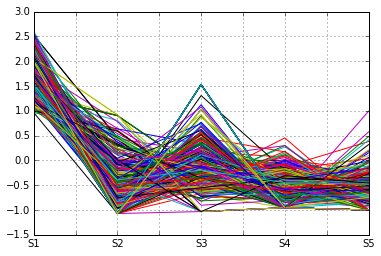

In [50]:
newData[newData.kmeans==4].T.drop('kmeans').plot(legend=False)

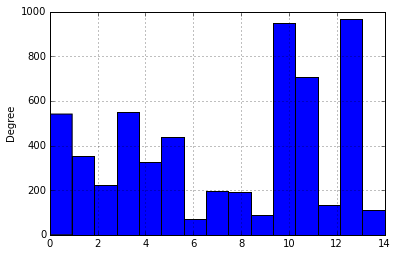

In [51]:
newData.kmeans.plot(kind='hist',bins=15)

Automatically created module for IPython interactive environment
For n_clusters = 4 The average silhouette_score is : 0.4252539038


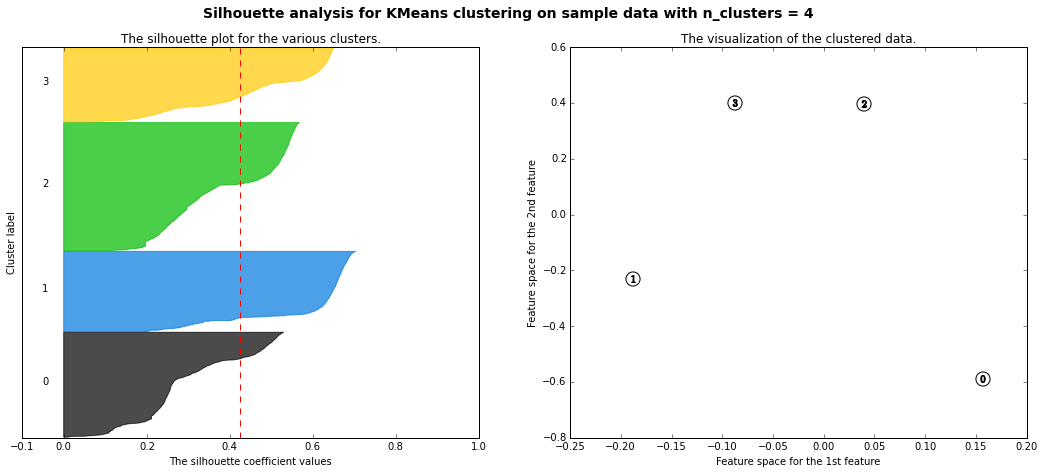

For n_clusters = 5 The average silhouette_score is : 0.450057777179


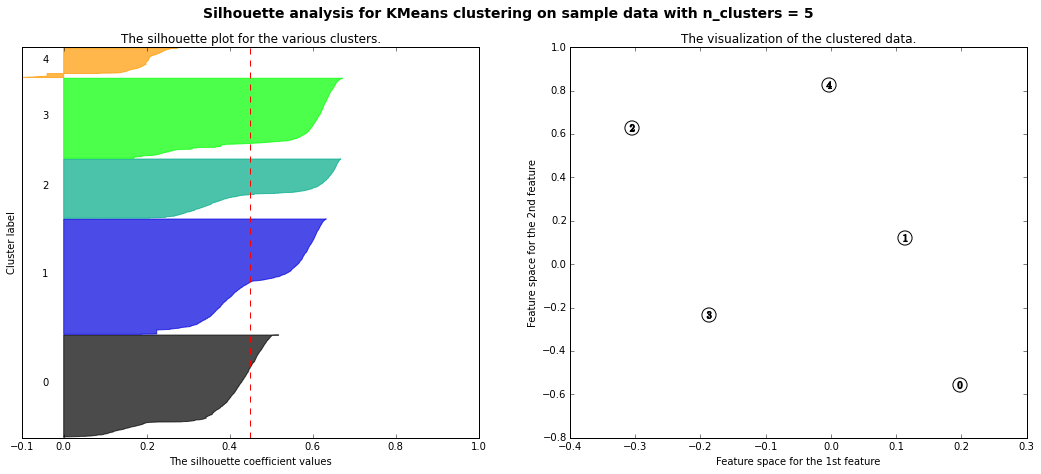

For n_clusters = 6 The average silhouette_score is : 0.460283512722


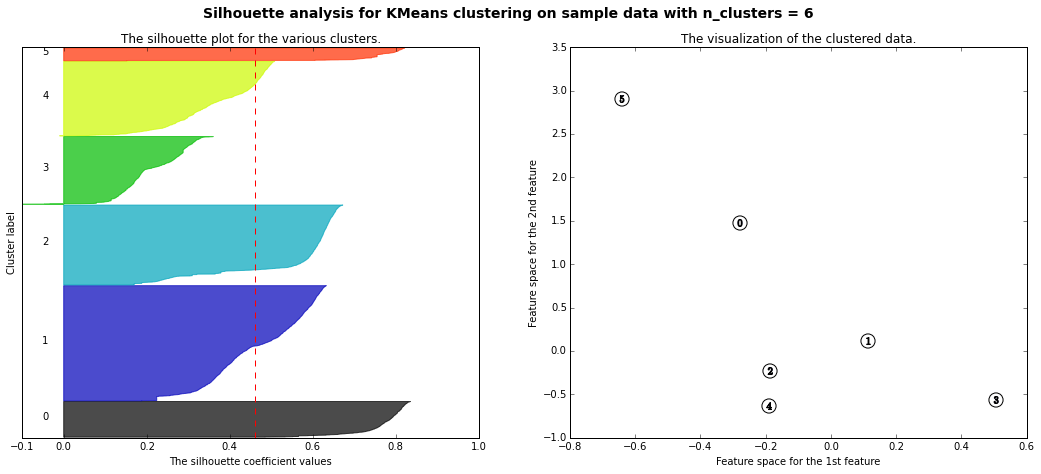

For n_clusters = 7 The average silhouette_score is : 0.494422843003


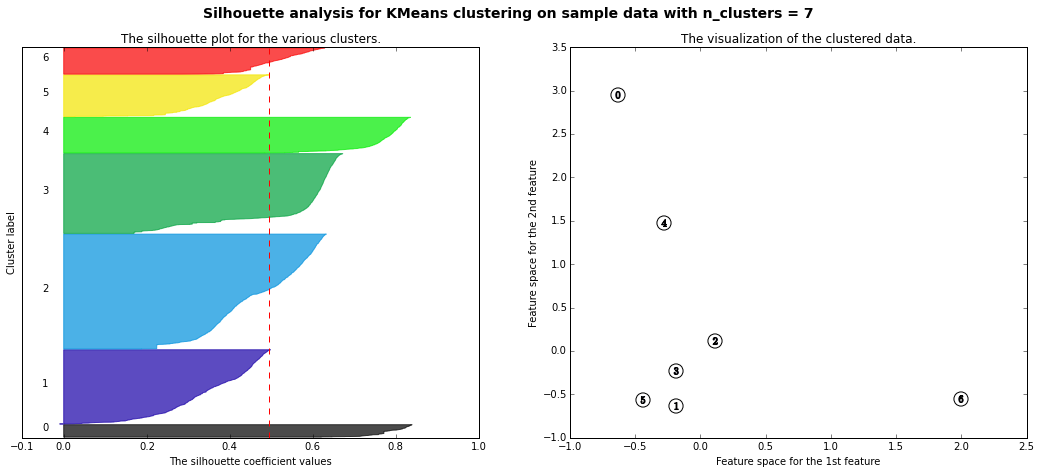

For n_clusters = 8 The average silhouette_score is : 0.50923729467


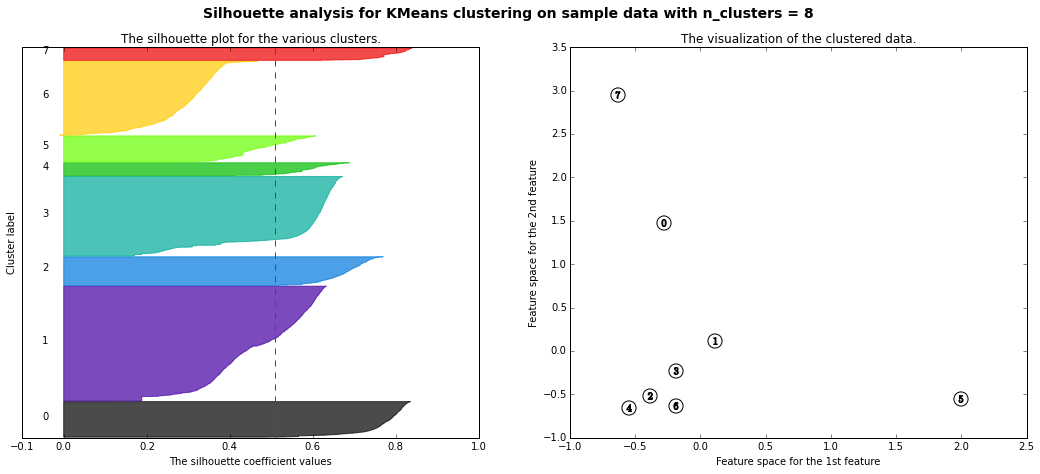

In [52]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

def silhoetteAnalysis(X, range_n_clusters):

    # Generating the sample data from make_blobs
    # This particular setting has one distict cluster and 3 clusters placed close
    # together.


    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhoutte score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
#         ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
#                     c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

    
range_n_clusters=np.arange(4,9)    
silhoetteAnalysis(newData, range_n_clusters)

('For n_clusters =', 10, 'The average silhouette_score is :', 0.66646639973173338)


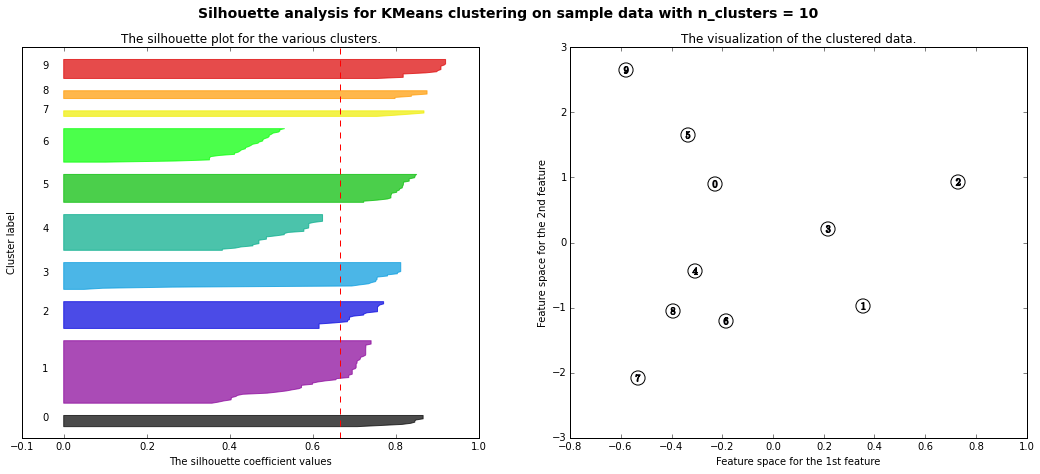

('For n_clusters =', 11, 'The average silhouette_score is :', 0.68745681575699558)


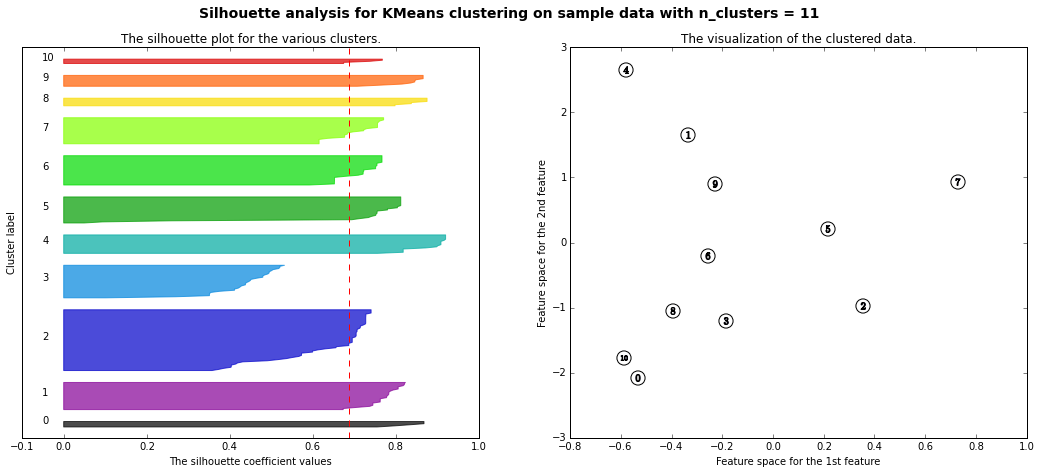

('For n_clusters =', 12, 'The average silhouette_score is :', 0.71890433494929651)


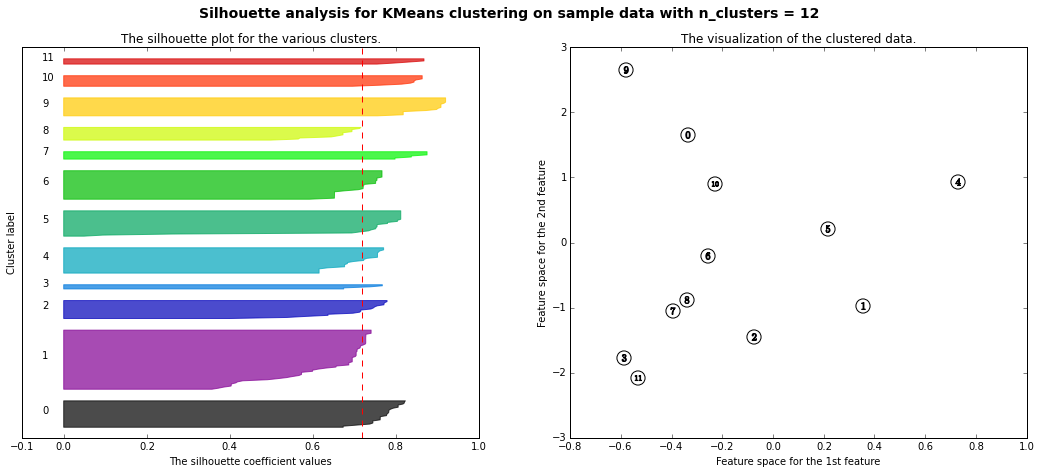

('For n_clusters =', 13, 'The average silhouette_score is :', 0.71959756143969333)


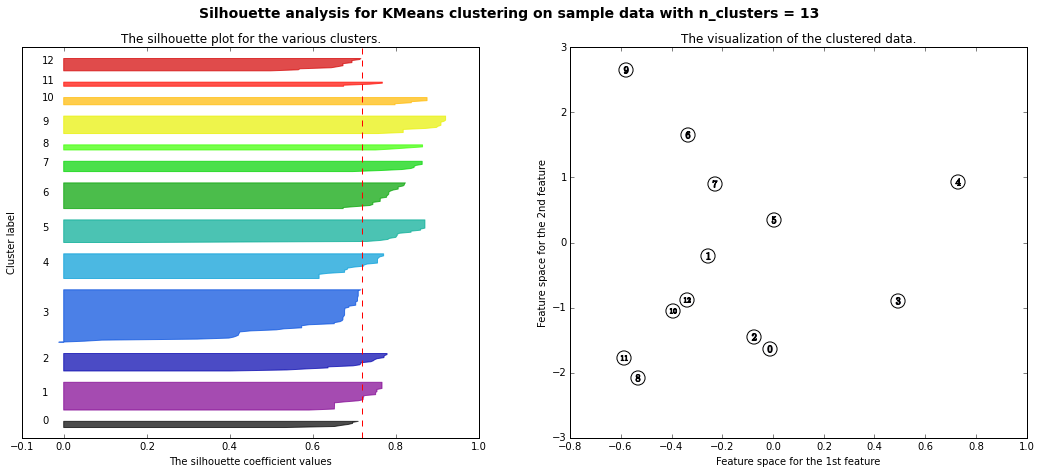

('For n_clusters =', 14, 'The average silhouette_score is :', 0.73221736151145511)


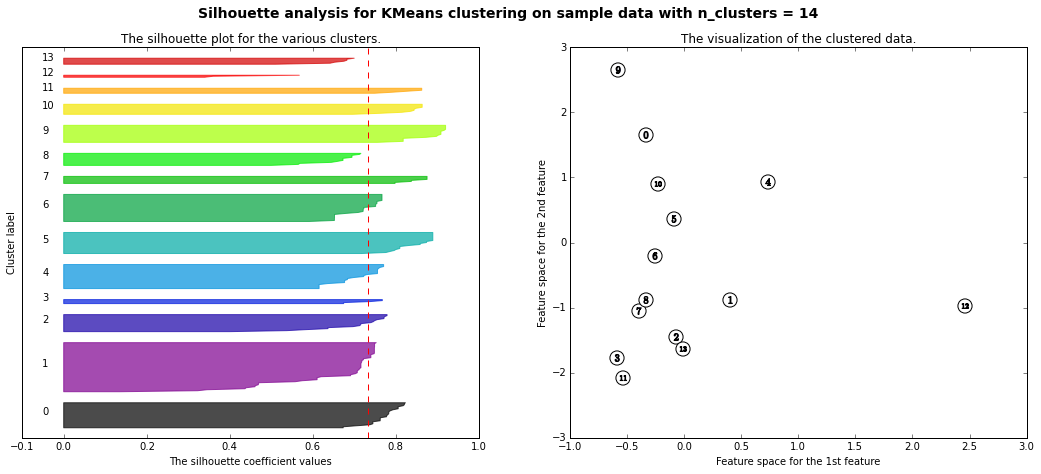

In [406]:
range_n_clusters=np.arange(10,15)    
silhoetteAnalysis(newData, range_n_clusters)

In [209]:
kmeans=KMeans(n_clusters=12)


kmeans.fit(newData)

newData['kmeans']=kmeans.labels_

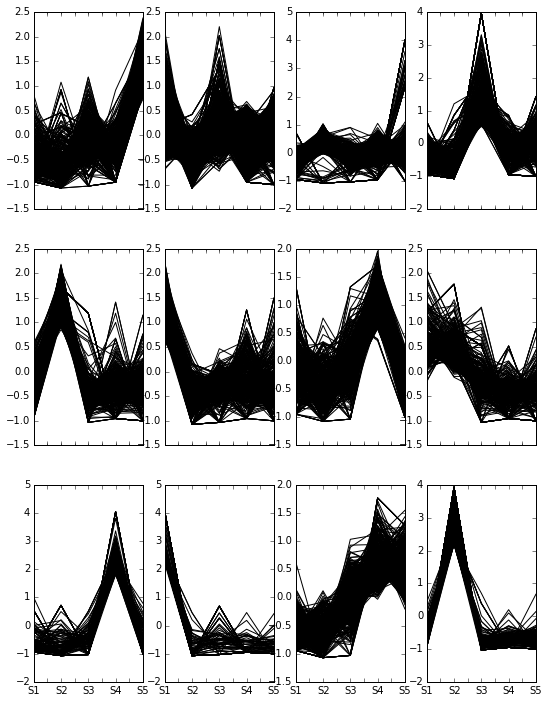

In [252]:
fig,axs=plt.subplots(3,4)
axs=[item for sublist in axs for item in sublist]
fig.set_size_inches(9,12)
for ax, y in zip(axs,range(12)):
    if y==0: 
        cc='k'
    else: 
        cc=cm.spectral(float(y)/12)
    pltData=newData[newData.kmeans==y].T.drop('kmeans')
    pltData.plot(ax=ax, legend=False, grid=False, color='k')


(0.84315882352941185, 0.0, 0.0, 1.0)